# Header

**NB:** You need 120g to run this entire notebook!

In [ ]:
import os
from scipy import signal, stats
import numpy as np

# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# import modin.pandas as pd
import pandas as pd

import bisect
import importlib
import warnings
from pathlib import Path
import gc

# from tqdm.notebook import trange, tqdm
# # Create new `pandas` methods which use `tqdm` progress
# tqdm.pandas()

import ete3
np.random.seed(7)

# import psutil, os
# def mem():
#     return psutil.Process(os.getpid()).memory_info().rss / 1024**3

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)

from shared_vars_and_func import *

Monospace font for numbers in tables:

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

In [4]:
remapped_data_path = data_path / 'composition_cpg_remapped'

## Load species details

In [5]:
species_details = pd.read_csv('/home/kmt/Birds/faststorage/data/species_details.txt', sep='\t')
species_details.head()

,species2014,species,english,latin,group,family,male_min,male_max,female_min,female_max,weight,order,order2014,branch_length
0,PICPU,PICPU,Downy Woodpecker,Picoides pubescens,woodpecker,woodpeckers,"20,70","32,20","20,70","32,20","26,45",39,1,0.143370
1,MERNU,MERNU,Carmine Bee-eater,Merops nubicus,woodpecker,bee-eaters,"34,00","59,00","34,00","59,00","46,5",38,2,0.102957
2,BUCRH,BUCRH,Rhinoceros Hornbill,Buceros rhinoceros,woodpecker,hornbills,"2465,00","2960,00","2040,00","2330,00","2448,75",37,3,0.099782
3,APAVI,APAVI,Bar-tailed Trogon,Apaloderma vittatum,woodpecker,trogons,"55,00","55,00","55,00","55,00",55,36,4,0.104832
4,LEPDI,LEPDI,Cuckoo Roller,Leptosomus discolor,woodpecker,cockoo-roller,"160,00","301,00","160,00","301,00","230,5",35,5,0.066956


# CGI data

In [6]:
cgi = pd.read_csv('/project/Birds/faststorage/data/bed/CGI-taeGut1.txt', sep='\t')
cgi['pos'] = (cgi.start + (cgi.end - cgi.start) / 2).round().astype(int)
cgi['chrom'] = cgi['chr'].str.replace('chr', '')
cgi.head()

,chr,start,end,length,CpGcount,GCcount,pctGC,obsExp,pos,chrom
0,chr1,21810,21940,131,9,83,0.633588,0.685465,21875,1
1,chr1,31020,31136,117,15,82,0.700855,1.054054,31078,1
2,chr1,32772,33056,285,23,202,0.708772,0.642584,32914,1
3,chr1,47794,48027,234,12,130,0.555556,0.668571,47910,1
4,chr1,108367,108549,183,9,93,0.508197,0.772514,108458,1


# Find size order of TAEGU chromosomes

In [7]:
from Bio import SeqIO
import gzip

records = []
with gzip.open('../../../../data/assembly/Taeniopygia_guttata.fa.gz', 'rt') as f:
    for record in SeqIO.parse(f, "fasta"):
        if record.id in chromosomes:
            records.append([record.id, len(record)])
taegu_chromosome_sizes = (pd.DataFrame()
                          .from_records(records, columns=['chrom', 'chrom_size'])
                          .sort_values(by='chrom_size', ascending=False)
                         )
taegu_chromosome_sizes

,chrom,chrom_size
15,2,156412533
14,1,118548696
13,3,112617285
12,1A,73657157
11,4,69780378
10,5,62374962
9,7,39844632
8,6,36305782
7,9,27241186
6,12,21576510


In [8]:
taegu_chromosome_sizes.to_hdf('../results/taegu_chromosome_sizes.h5', key='df', format='table')

# Hotspot data

In [9]:
hotspots = pd.read_csv('/project/Birds/faststorage/data/bed/hotspots.bed', names=['chrom', 'start', 'end'], sep='\t')
hotspots['pos'] = (hotspots.start + (hotspots.end - hotspots.start) / 2).round().astype(int)
hotspots['chrom'] = hotspots.chrom.str.replace('chr', '')
hotspots.rename(columns={'stop': 'end'}, inplace=True)
hotspots.head()

,chrom,start,end,pos
0,1,6892116,6896116,6894116
1,1,8803005,8807005,8805005
2,1,9684030,9690030,9687030
3,1,10395061,10399061,10397061
4,1,10500751,10506751,10503751


In [10]:
hotspots.pos.unique().size

2856

Function for reducing memory of data frames:

# Data mapped relative to hotspots (hotspot_data)

In [11]:
branch_lengths = pd.read_hdf('../results/branch_lengths.h5')

All 1kb windows overlapping hotspot center are set to zero distance. For all other windows, the distance is the distane to the closest hotspot center.

In [12]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.hotspot_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
hotspot_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

In [13]:
del df_list
gc.collect()

0

Optimize data frame. Exclude one of the eagles. We also exclude windows smaller than 1000. These are split windows overlapping midpoint between two hotspots. 

In [14]:
def data_filter(df):
    include_species = ~df.species.isin(['HALAL'])
    win_size = (df.end - df.start).abs()
    include_window = (win_size == 1000) | (win_size == 0)
    return include_species & include_window

hotspot_data = optimize_data_frame(hotspot_table).loc[data_filter]
hotspot_data['species'] = hotspot_data['species'].cat.remove_unused_categories()

In [15]:
len(hotspot_table.start_prox.unique())

2856

In [16]:
del hotspot_table
gc.collect()

31

In [17]:
hotspot_data['hotspot_center'] = (hotspot_data.start_prox + (hotspot_data.end_prox - hotspot_data.start_prox) / 2).astype('int32')

Add species names:

In [18]:
hotspot_data['species_code'] = hotspot_data.species
name_mapping = dict(zip(species_details.species2014, species_details.english))
hotspot_data['species'] = [name_mapping[x] for x in hotspot_data.species_code]

hotspot_data['species'] = hotspot_data['species'].astype('category')

Compute the number of aligned bases in each window:

In [19]:
hotspot_data['nr_aligned'] = hotspot_data[base_counts].sum(axis=1)

Compute substitution rates across each external branch by dividing substitution counts by the ancestral count of the base substituted from:

In [20]:
for subst in substitution_counts:
    from_base, to_base = subst[1], subst[3]
    
    adding_subst = [x for x in substitution_counts if x[3] == from_base]
    removing_subst = [x for x in substitution_counts if x[1] == from_base]
    
    hotspot_data[subst.replace('n', 'r')] = hotspot_data[subst] / \
        (hotspot_data['n' + from_base] - hotspot_data[adding_subst].sum(axis=1) + hotspot_data[removing_subst].sum(axis=1))

Normalize so rates are relative to so they are relative to the 30kb - 40kb flanks:

In [21]:
flank_rates = (hotspot_data.loc[(hotspot_data.bin.abs() > 30000) & (hotspot_data.bin.abs() <= 40000)]
               .groupby(['species_code'], observed=False)
               [substitutions]
               .mean()
              )
df = hotspot_data.merge(flank_rates, on='species_code', how='left', suffixes=('_raw', '_flank_mean'))
for pattern in substitutions:
    hotspot_data[pattern] = df[pattern + '_raw'] /  df[pattern + '_flank_mean']

In [22]:
len(hotspot_data.species.unique())

47

In [23]:
hotspot_data.head()

,ancestor,bin,chrom,end,end_orig,end_prox,nA,nA2C,nA2G,nA2T,...,rA2T,rC2A,rC2G,rC2T,rG2A,rG2C,rG2T,rT2A,rT2C,rT2G
0,Anc44,0.0,1,0,6895000,6894116,94,2,3,1,...,1.545756,0.000000,0.000000,1.720014,0.333886,0.000000,1.900608,1.466207,1.103749,1.666186
1,Anc44,0.0,1,0,8806000,8805005,295,1,6,2,...,1.027011,1.415039,0.000000,0.249238,0.665874,0.000000,1.895209,2.229067,0.839012,1.266547
2,Anc44,0.0,1,0,9688000,9687030,291,2,4,1,...,0.520564,0.578545,1.356067,0.407607,0.744088,0.000000,2.117820,1.013552,0.381497,1.151793
3,Anc44,0.0,1,0,10398000,10397061,261,3,6,2,...,1.160797,1.089025,0.000000,0.767261,1.882632,0.778834,0.669793,0.545196,1.641678,0.000000
4,Anc44,0.0,1,0,10504000,10503751,113,0,1,2,...,2.779524,0.698620,0.000000,0.492205,0.988978,2.454806,1.407412,2.127032,0.800607,1.208571


-----

In [24]:
# (subst_data
#  .loc[subst_data.bin.abs() > 30000]
#  .groupby(['species_code', 'pattern'], observed=False)
#  .rate
#  .mean()
#  .reset_index()
#  .rename(columns={'rate':'flank_rate'}) 
# ).merge(subst_data, on=['species_code', 'pattern'], how='right')

# (subst_data
#  .rename(columns={'rate':'raw_rate'})
#  .merge(mean_flank_rates, on=['species_code', 'pattern'], how='left')
# )                                                            

In [25]:

# (subst_data
#  .head()
#  .groupby(['species_code', 'pattern'], observed=False)
#  .apply(lambda df: df['rate']/df.loc[subst_data.bin.abs() > 30000, 'rate'])
#  .reset_index()
# )

-----

In [26]:
hotspot_data.to_hdf('../results/hotspot_data.h5', key='df', format='table')

Make a copy of the entire data frame and do the same but including CpG sites:

In [27]:
hotspot_data_incl_cpg = hotspot_data.copy(deep=True)

for subst in substitution_counts:
    from_base, to_base = subst[1], subst[3]
    
    adding_subst = [x for x in substitution_counts+cpg_substitution_counts if x[3].upper() == from_base]
    removing_subst = [x for x in substitution_counts+cpg_substitution_counts if x[1].upper() == from_base]
    
    same_subst = [x for x in substitution_counts+cpg_substitution_counts if x[1:].upper() == subst[1:]]
   
    from_base_count = hotspot_data['n' + from_base]
    if from_base in 'GC':
        from_base_count += hotspot_data['n' + from_base.lower()]

    hotspot_data_incl_cpg[subst.replace('n', 'r')] = hotspot_data[same_subst].sum(axis=1) / \
            (from_base_count - hotspot_data[adding_subst].sum(axis=1) + hotspot_data[removing_subst].sum(axis=1))    

Normalize so rates are relative to so they are relative to the 30kb - 40kb flanks:

In [28]:
flank_rates_incl_cpg = (hotspot_data_incl_cpg.loc[(hotspot_data_incl_cpg.bin.abs() > 30000) & (hotspot_data_incl_cpg.bin.abs() <= 40000)]
               .groupby(['species_code'], observed=False)
               [substitutions]
               .mean()
              )
df = hotspot_data_incl_cpg.merge(flank_rates_incl_cpg, on='species_code', how='left', suffixes=('_raw', '_flank_mean'))
for pattern in substitutions:
    hotspot_data_incl_cpg[pattern] = df[pattern + '_raw'] /  df[pattern + '_flank_mean']

In [29]:
hotspot_data_incl_cpg.head()

,ancestor,bin,chrom,end,end_orig,end_prox,nA,nA2C,nA2G,nA2T,...,rA2T,rC2A,rC2G,rC2T,rG2A,rG2C,rG2T,rT2A,rT2C,rT2G
0,Anc44,0.0,1,0,6895000,6894116,94,2,3,1,...,1.519164,0.000000,0.000000,1.584016,0.584614,0.000000,1.559202,1.456257,1.356284,2.861046
1,Anc44,0.0,1,0,8806000,8805005,295,1,6,2,...,1.026462,1.250573,0.710605,0.372888,0.578493,0.000000,1.538412,2.235436,0.867488,1.097966
2,Anc44,0.0,1,0,9688000,9687030,291,2,4,1,...,0.523850,0.555458,1.364362,0.767819,1.032637,0.000000,2.097835,1.023316,0.317688,1.005233
3,Anc44,0.0,1,0,10398000,10397061,261,3,6,2,...,1.146539,1.032313,0.000000,0.683628,1.733210,0.762197,0.620327,0.546754,1.357916,0.000000
4,Anc44,0.0,1,0,10504000,10503751,113,0,1,2,...,2.839559,0.569923,0.000000,0.613650,1.144996,1.817024,1.809897,2.194939,0.681418,1.078075


In [30]:
hotspot_data_incl_cpg.to_hdf('../results/hotspot_data_incl_cpg.h5', key='df', format='table')

In [31]:
del hotspot_data
gc.collect()

463

In [32]:
del hotspot_data_incl_cpg
gc.collect()

0

# Long format hotspot data (subst_data)

Make a long format data frames with substitution rate data within 40kb from each hotspot:

In [33]:
hotspot_data = pd.read_hdf('../results/hotspot_data.h5')

In [34]:
id_cols = ['species', 'species_code', 'ancestor', 'hotspot_center', 'bin', 'branch_length', 'ultra_branch_length', 'nr_aligned']
subst_data = (hotspot_data
              .loc[lambda df: df.bin.abs() <= 40000, id_cols + substitutions + base_counts]
              .melt(id_vars=id_cols,
                    value_vars=substitutions,
                    var_name='pattern', value_name='rate')
             )
subst_data['pattern'] = pd.Categorical(subst_data.pattern.values, 
                                       categories=substitutions, ordered=True)
subst_data.loc[subst_data.pattern.isin(transitions), 'type'] = 'Transition'
subst_data.loc[~subst_data.pattern.isin(transitions), 'type'] = 'Transversion'
subst_data['type'] = pd.Categorical(subst_data.type.values, categories=['Transition', 'Transversion'], ordered=True)
subst_data.head()

,species,species_code,ancestor,hotspot_center,bin,branch_length,ultra_branch_length,nr_aligned,pattern,rate,type
0,American Crow,CORBR,Anc44,6894116,0.0,0.038474,0.035454,409,rA2C,3.508902,Transversion
1,American Crow,CORBR,Anc44,8805005,0.0,0.038474,0.035454,899,rA2C,0.582835,Transversion
2,American Crow,CORBR,Anc44,9687030,0.0,0.038474,0.035454,991,rA2C,1.181692,Transversion
3,American Crow,CORBR,Anc44,10397061,0.0,0.038474,0.035454,908,rA2C,1.976278,Transversion
4,American Crow,CORBR,Anc44,10503751,0.0,0.038474,0.035454,568,rA2C,0.000000,Transversion


## Number of aligned bases and filtering

Distribution of number of aligned bases in windows for TAEGU:

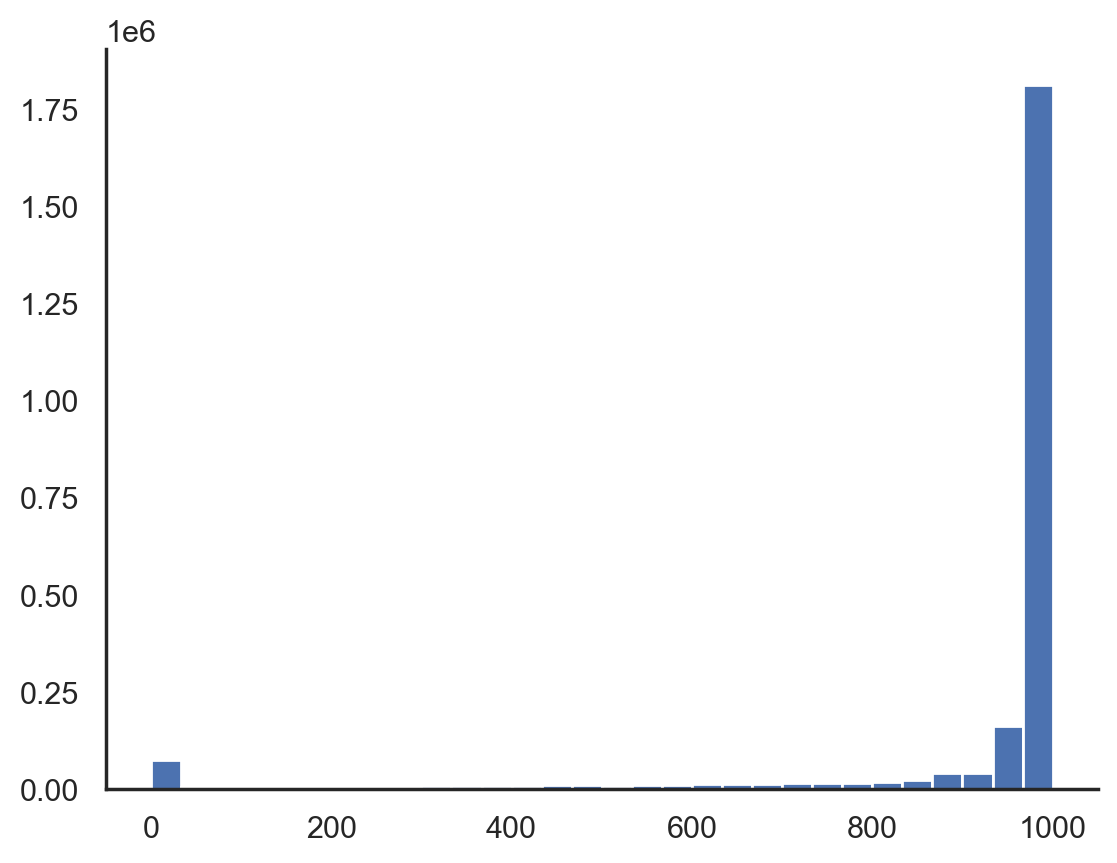

In [35]:
plt.hist(subst_data.loc[subst_data.species_code == 'TAEGU'].nr_aligned, bins=30)
sns.despine()
plt.savefig(figures_path / 'distr_nr_aligned_bases.pdf')

Distribution of number of aligned bases in windows for all others:

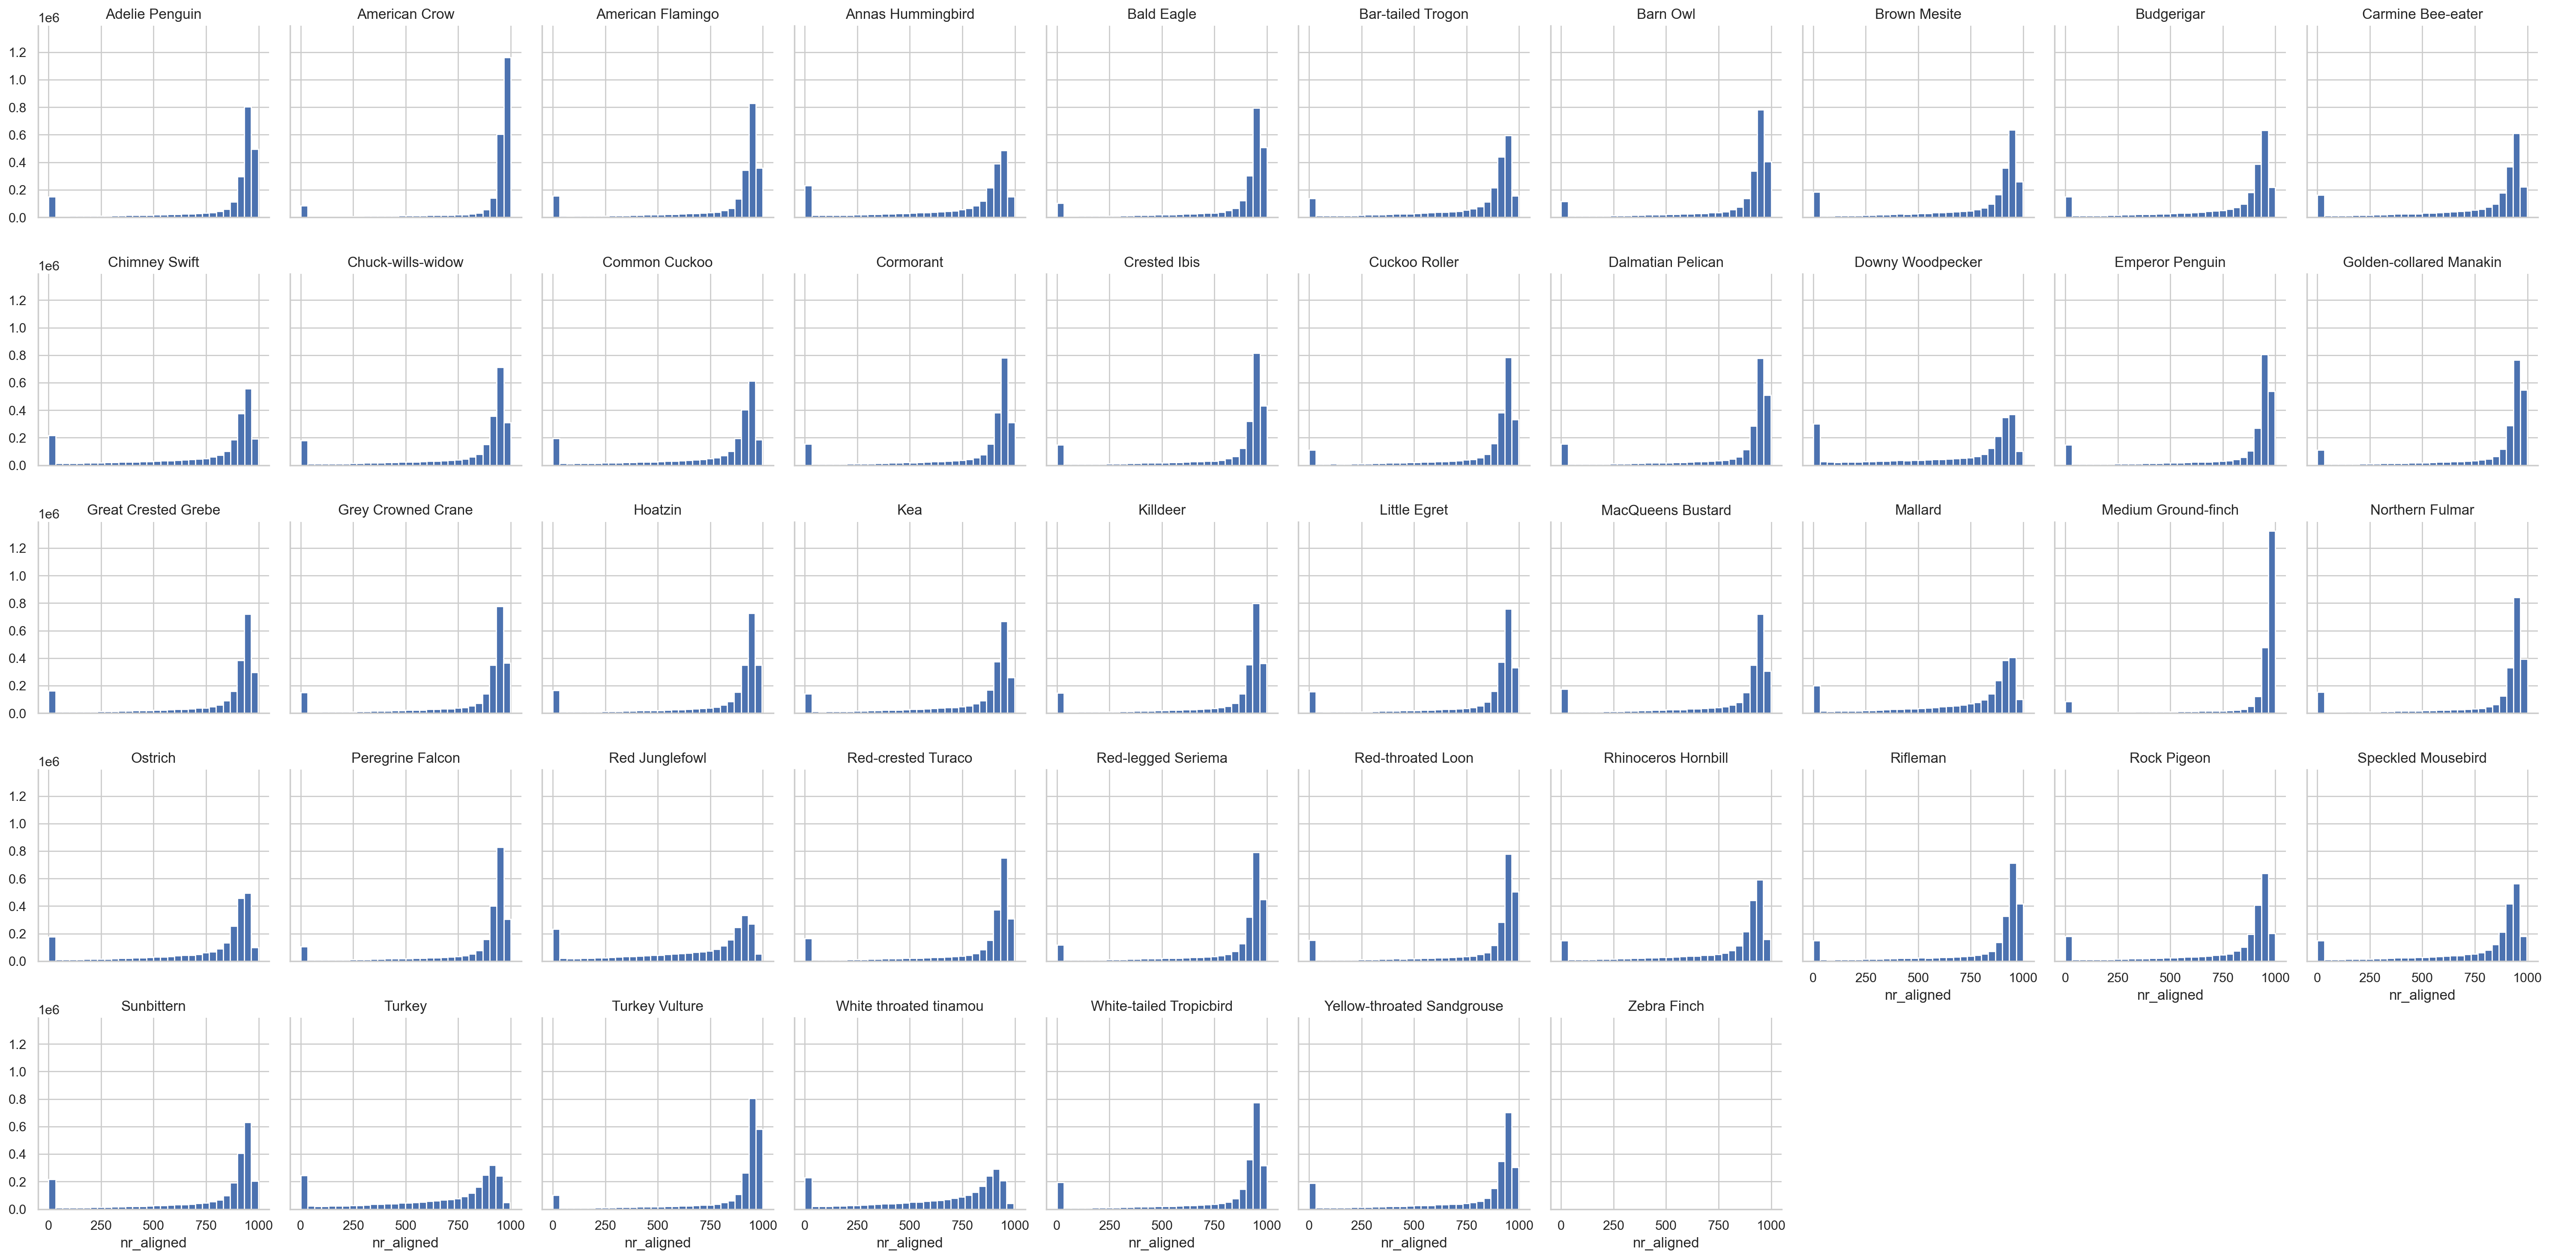

In [36]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(subst_data.loc[subst_data.species_code != 'TAEGU'], col='species', col_wrap=10, sharey=True)
    g.map(plt.hist, 'nr_aligned', bins=30).add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;
    plt.savefig(figures_path / 'distr_nr_aligned_bases_indiv_species.pdf')    

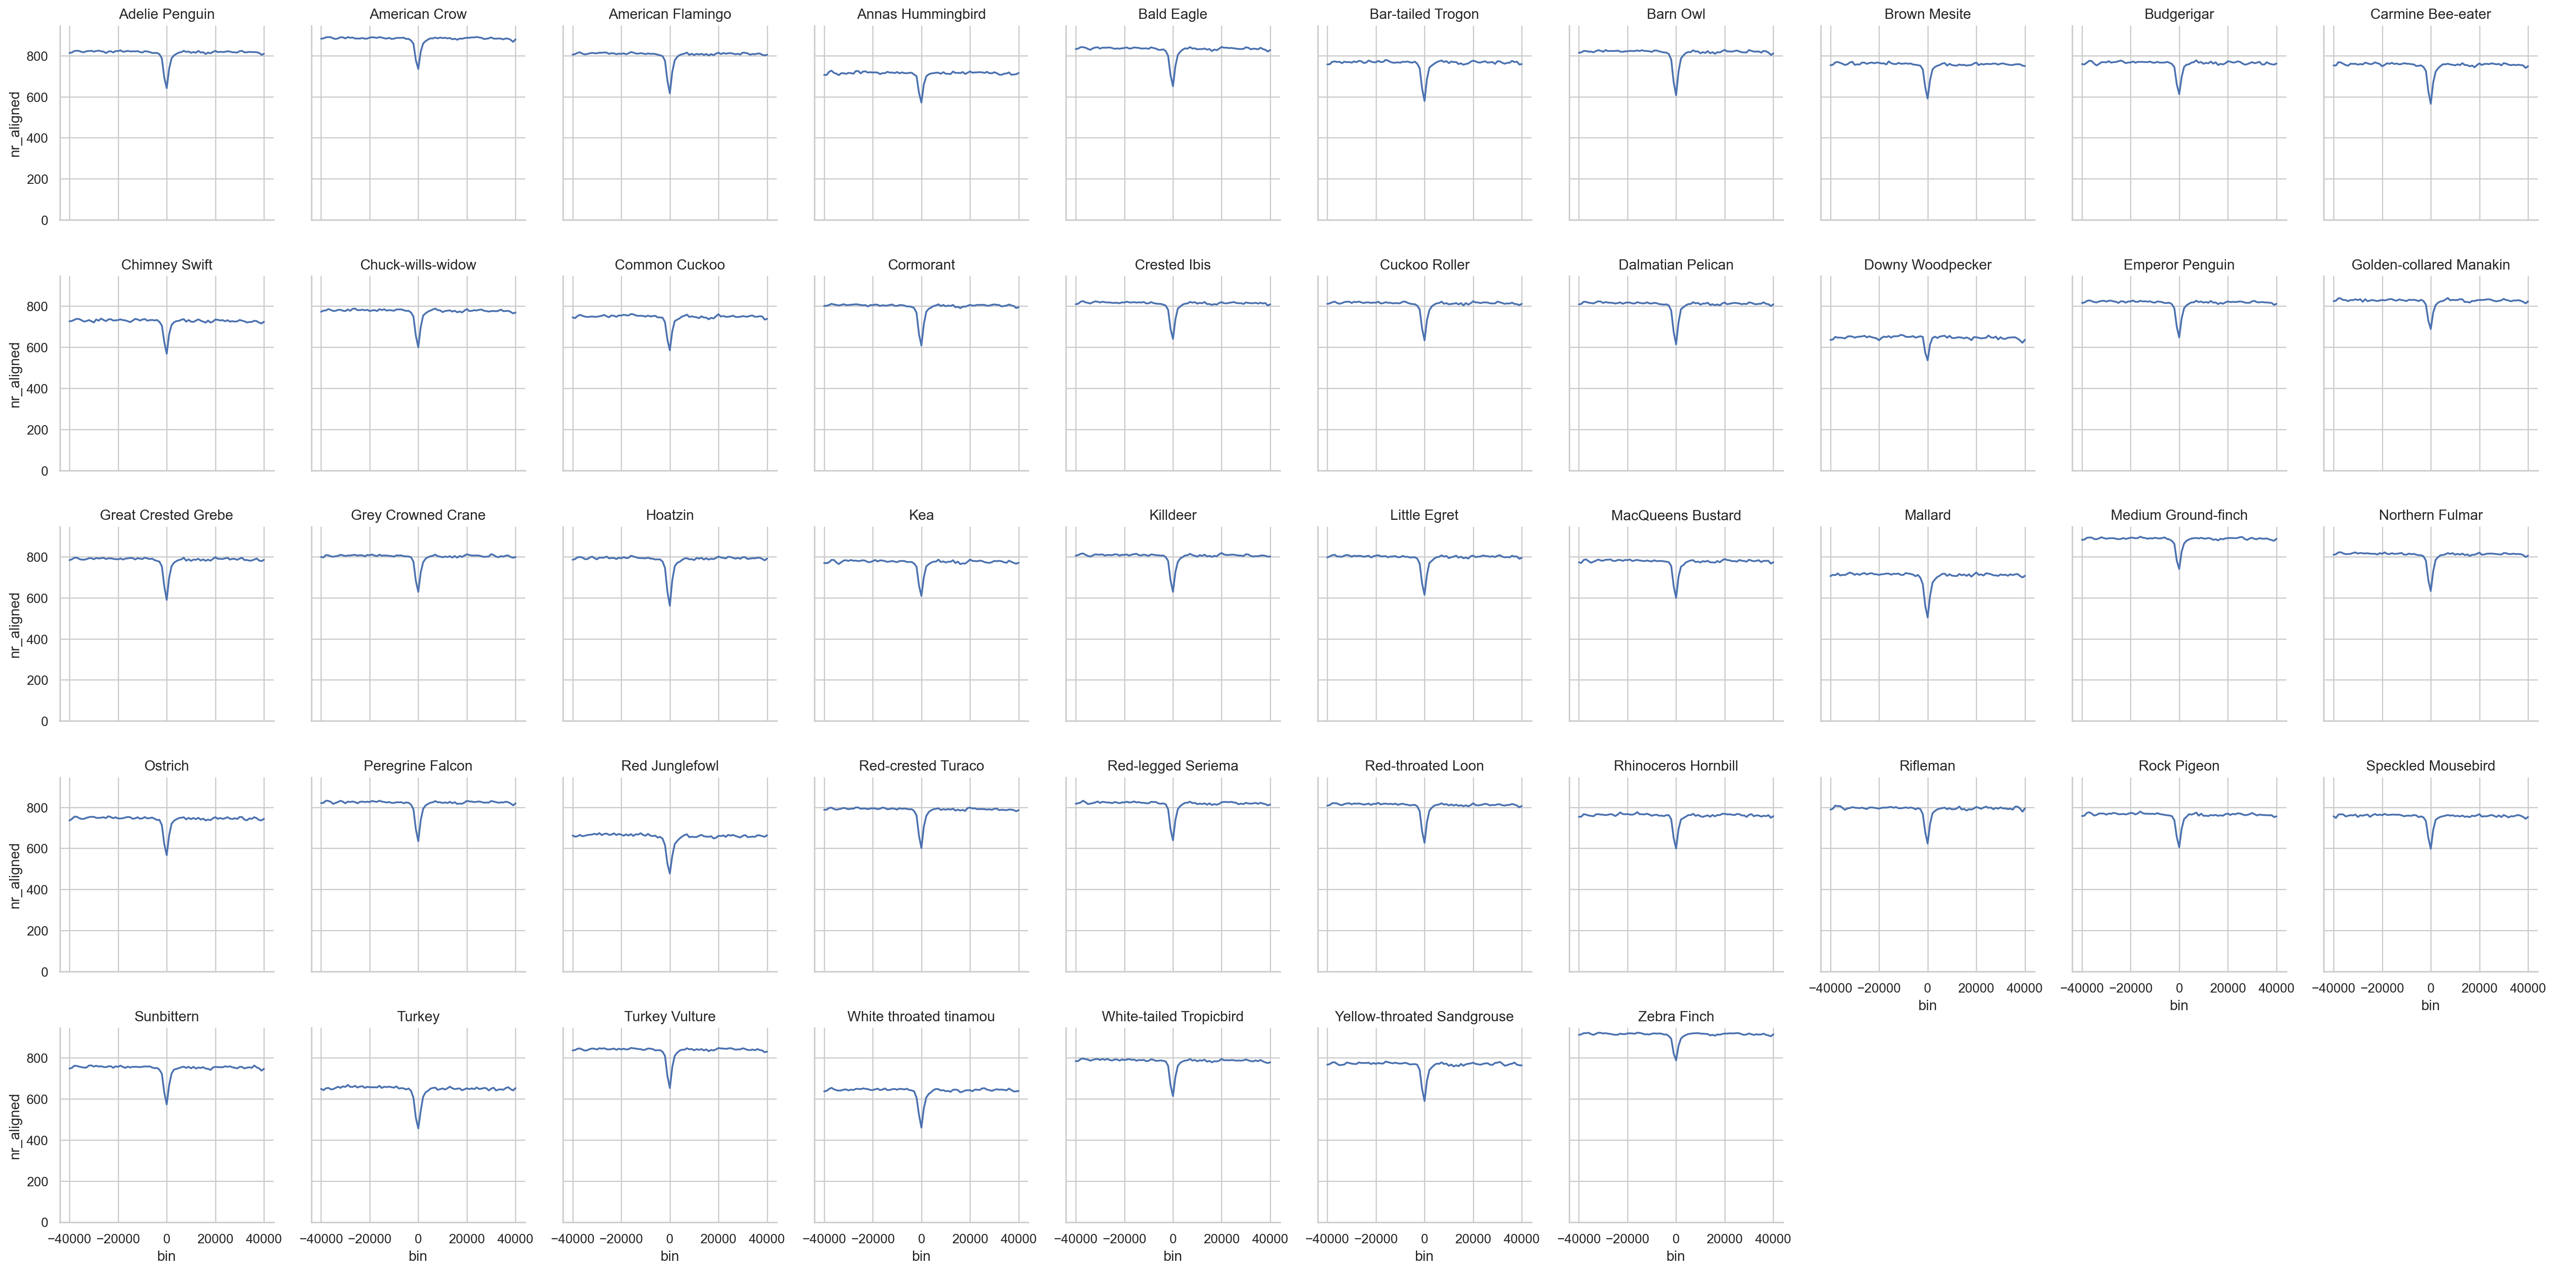

In [37]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(subst_data,
                      col='species', col_wrap=10, sharey=True)
    g.map(sns.lineplot, 'bin', 'nr_aligned', errorbar=None).add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;
    [ax.set_ylim(bottom=0) for ax in g.axes.flat]
    plt.savefig(figures_path / 'nr_aligned_base_across_hotspots_indiv_species.pdf')        

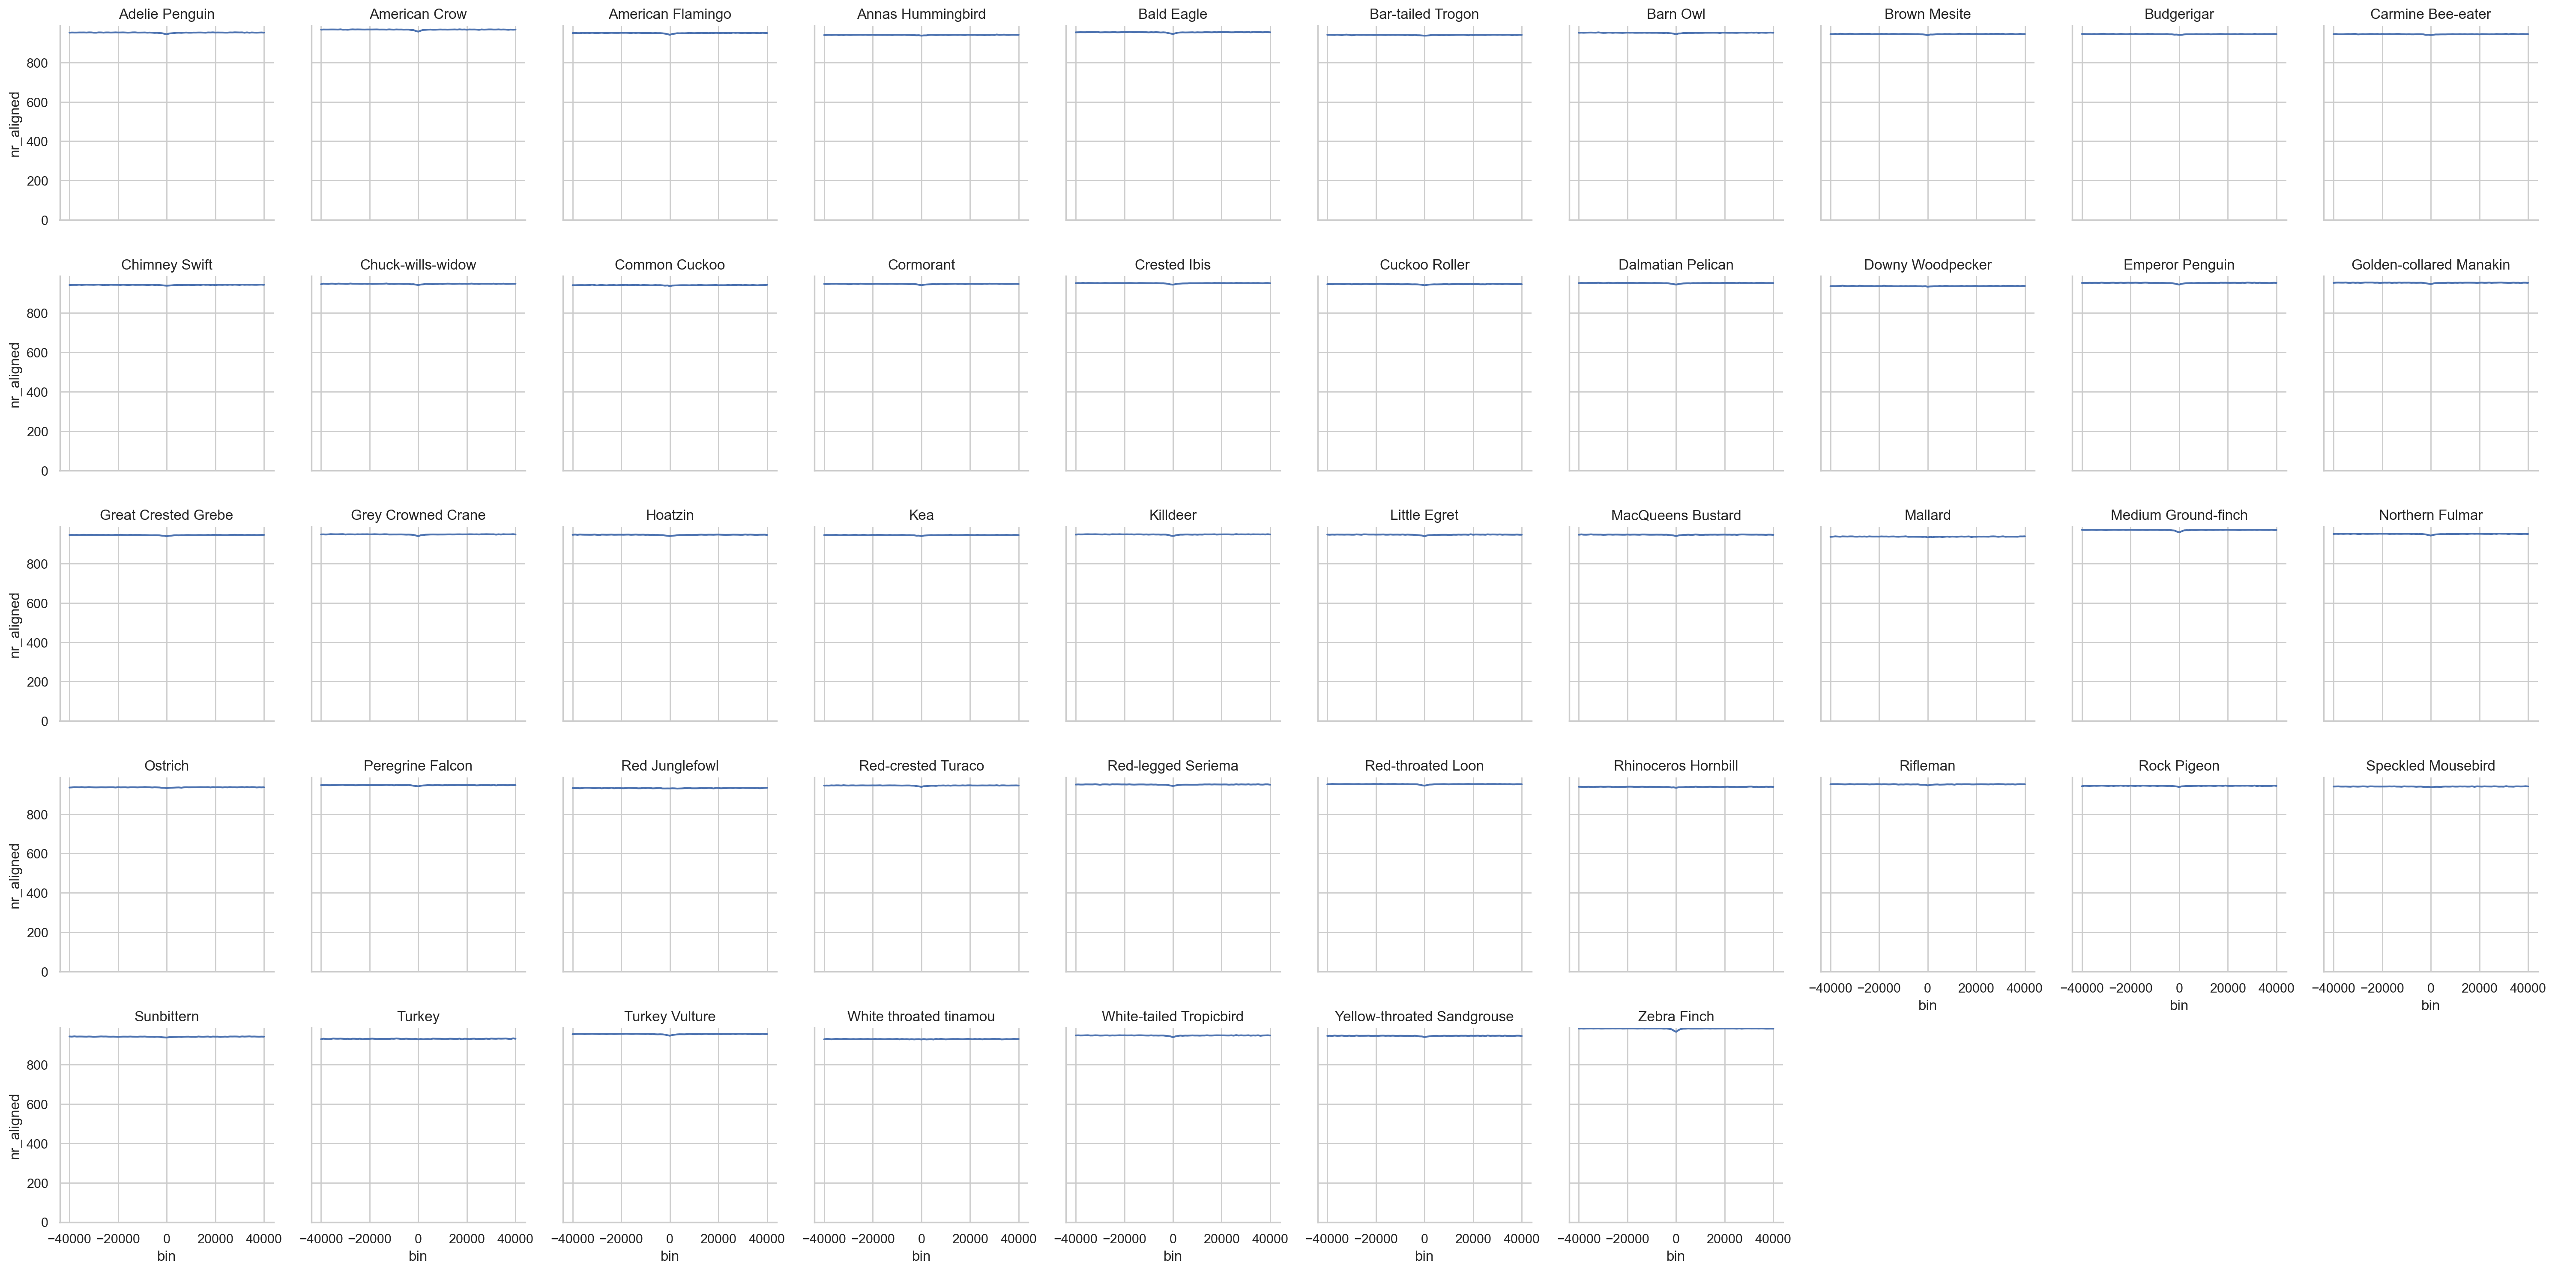

In [38]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(subst_data.loc[subst_data.nr_aligned >= 900],
                      col='species', col_wrap=10, sharey=True)
    g.map(sns.lineplot, 'bin', 'nr_aligned', errorbar=None).add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}') ;
    [ax.set_ylim(bottom=0) for ax in g.axes.flat]
    plt.savefig(figures_path / 'nr_aligned_base_across_hotspots_indiv_species_only_min900bases.pdf')            

> It seems there are important differences in the alignemnt quality in the different species. Especially with some of the long branches. 

> We will be asked how much of the differences we find are due to misalignemnts. To that we can say that any misalignment will inflate all substitution rates at hotspots not just a few. As we show further down, the A2T and T2A substitution rates are constant across the hotspots.

We use only windows where with at least 300 aligned bases. (below we also test if this cutoff matters to the patterns observed)

In [39]:
removed_rows = subst_data[subst_data.nr_aligned < 300].index
subst_data.drop(removed_rows, inplace=True)

Normalize each substitution rate with a global mutation rate divided by the external branch length. 

By dividing by branch length we take variation in overall subsititution rate into account. This should make the summed substitituion rates outside hotspots should be the same across species.

In [40]:
# subst_data['rate'] *= 2.3e-9 / subst_data.branch_length * 1e9 
subst_data['rate'] /= subst_data.branch_length
optimize_data_frame(subst_data, inplace=True)
subst_data.head()

,species,species_code,ancestor,hotspot_center,bin,branch_length,ultra_branch_length,nr_aligned,pattern,rate,type
0,American Crow,CORBR,Anc44,6894116,0.0,0.038474,0.035454,409,rA2C,91.202676,Transversion
1,American Crow,CORBR,Anc44,8805005,0.0,0.038474,0.035454,899,rA2C,15.148919,Transversion
2,American Crow,CORBR,Anc44,9687030,0.0,0.038474,0.035454,991,rA2C,30.714303,Transversion
3,American Crow,CORBR,Anc44,10397061,0.0,0.038474,0.035454,908,rA2C,51.367024,Transversion
4,American Crow,CORBR,Anc44,10503751,0.0,0.038474,0.035454,568,rA2C,0.000000,Transversion


It seems one hotspot appears twice. Remove that one so positions remain unqiue across chromosomesÆ

In [41]:
subst_data = subst_data.loc[subst_data.hotspot_center != 11341000]

In [42]:
subst_data.to_hdf('../results/subst_data.h5', key='df', format='table')

And the same including CpG sites:

In [43]:
hotspot_data_incl_cpg = pd.read_hdf('../results/hotspot_data_incl_cpg.h5')

In [44]:
subst_data_incl_cpg = (hotspot_data_incl_cpg
              .loc[lambda df: df.bin.abs() <= 40000, id_cols + substitutions + base_counts]
              .melt(id_vars=id_cols,
                    value_vars=substitutions,
                    var_name='pattern', value_name='rate')
             )
subst_data_incl_cpg['pattern'] = pd.Categorical(subst_data_incl_cpg.pattern.values, 
                                       categories=substitutions, ordered=True)
subst_data_incl_cpg.loc[subst_data_incl_cpg.pattern.isin(transitions), 'type'] = 'Transition'
subst_data_incl_cpg.loc[~subst_data_incl_cpg.pattern.isin(transitions), 'type'] = 'Transversion'
subst_data_incl_cpg['type'] = pd.Categorical(subst_data_incl_cpg.type.values, categories=['Transition', 'Transversion'], ordered=True)
subst_data_incl_cpg.head()

,species,species_code,ancestor,hotspot_center,bin,branch_length,ultra_branch_length,nr_aligned,pattern,rate,type
0,American Crow,CORBR,Anc44,6894116,0.0,0.038474,0.035454,409,rA2C,4.471794,Transversion
1,American Crow,CORBR,Anc44,8805005,0.0,0.038474,0.035454,899,rA2C,0.503580,Transversion
2,American Crow,CORBR,Anc44,9687030,0.0,0.038474,0.035454,991,rA2C,1.027999,Transversion
3,American Crow,CORBR,Anc44,10397061,0.0,0.038474,0.035454,908,rA2C,1.687469,Transversion
4,American Crow,CORBR,Anc44,10503751,0.0,0.038474,0.035454,568,rA2C,0.000000,Transversion


We use only windows where with at least 300 aligned bases. (below we also test if this cutoff matters to the patterns observed)

In [45]:
removed_rows = subst_data_incl_cpg[subst_data_incl_cpg.nr_aligned < 300].index
subst_data_incl_cpg.drop(removed_rows, inplace=True)

Normalize each substitution rate with a global mutation rate divided by the external branch length. 

By dividing by branch length we take variation in overall subsititution rate into account. This should make the summed substitituion rates outside hotspots should be the same across species.

In [46]:
# subst_data_incl_cpg['rate'] *= 2.3e-9 / subst_data_incl_cpg.branch_length * 1e9 
subst_data_incl_cpg['rate'] /= subst_data_incl_cpg.branch_length
optimize_data_frame(subst_data_incl_cpg, inplace=True)
subst_data_incl_cpg.head()

,species,species_code,ancestor,hotspot_center,bin,branch_length,ultra_branch_length,nr_aligned,pattern,rate,type
0,American Crow,CORBR,Anc44,6894116,0.0,0.038474,0.035454,409,rA2C,116.229975,Transversion
1,American Crow,CORBR,Anc44,8805005,0.0,0.038474,0.035454,899,rA2C,13.088961,Transversion
2,American Crow,CORBR,Anc44,9687030,0.0,0.038474,0.035454,991,rA2C,26.719534,Transversion
3,American Crow,CORBR,Anc44,10397061,0.0,0.038474,0.035454,908,rA2C,43.860368,Transversion
4,American Crow,CORBR,Anc44,10503751,0.0,0.038474,0.035454,568,rA2C,0.000000,Transversion


It seems one hotspot appears twice...

In [47]:
subst_data_incl_cpg = subst_data_incl_cpg.loc[subst_data_incl_cpg.hotspot_center != 11341000]

In [48]:
subst_data_incl_cpg.to_hdf('../results/subst_data_incl_cpg.h5', key='df', format='table')

In [49]:
del hotspot_data
del hotspot_data_incl_cpg
gc.collect()

138140

See if the summed substitituion rates outside hotspots are the same across species:

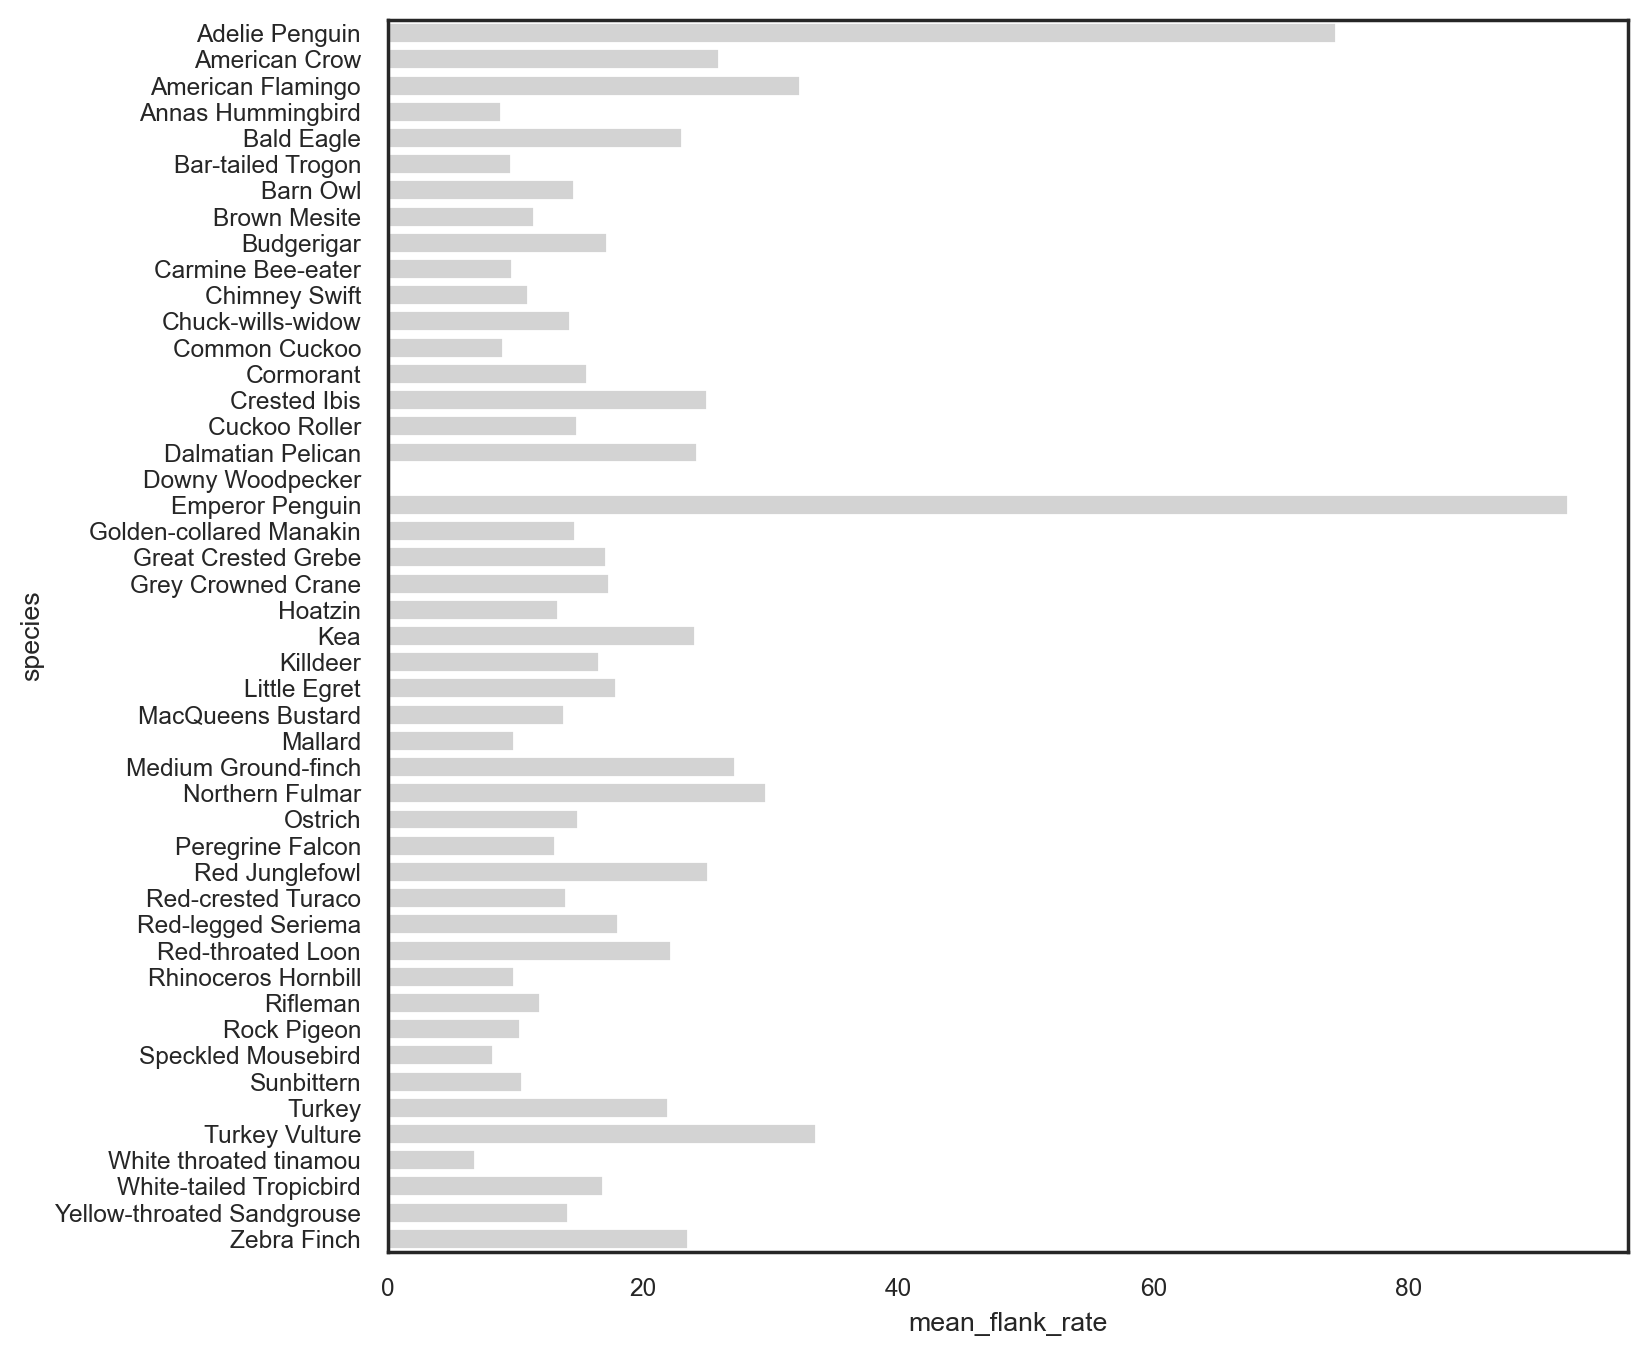

In [50]:
mean_flank_rates = (subst_data
                    .loc[subst_data.bin.abs() > 30000]
                    .groupby('species', observed=False)
                    .rate
                    .mean()
                    .reset_index()
                    .rename(columns={'rate': 'mean_flank_rate'})
                    )
with sns.plotting_context('notebook', font_scale=0.8):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y="species", x="mean_flank_rate", data=mean_flank_rates, color='lightgrey')
    plt.savefig(figures_path / 'mean_norm_flank_subst_rates.pdf')                

# Pivot table with column for each pattern (rate_table)

Rates are means across windows in the same position across hotspots.

In [51]:
subst_data.head()

,species,species_code,ancestor,hotspot_center,bin,branch_length,ultra_branch_length,nr_aligned,pattern,rate,type
0,American Crow,CORBR,Anc44,6894116,0.0,0.038474,0.035454,409,rA2C,91.202676,Transversion
1,American Crow,CORBR,Anc44,8805005,0.0,0.038474,0.035454,899,rA2C,15.148919,Transversion
2,American Crow,CORBR,Anc44,9687030,0.0,0.038474,0.035454,991,rA2C,30.714303,Transversion
3,American Crow,CORBR,Anc44,10397061,0.0,0.038474,0.035454,908,rA2C,51.367024,Transversion
4,American Crow,CORBR,Anc44,10503751,0.0,0.038474,0.035454,568,rA2C,0.000000,Transversion


In [52]:
rate_table = pd.pivot_table(subst_data, observed=False,
                            index=['species', 'species_code', 'bin'], columns='pattern', values='rate')
rate_table.columns = rate_table.columns.astype('str')
for a, b in paired_patterns:
    rate_table[f'{a}-{b}'] = rate_table[a] - rate_table[b]
rate_table.head()

pattern                                    rA2C       rT2G       rC2T  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  76.864717  75.820416  74.270473   
                            -39000.0  79.362589  74.821180  74.994079   
                            -38000.0  77.404157  76.798715  72.458711   
                            -37000.0  71.011059  73.374027  72.490921   
                            -36000.0  77.460664  76.326833  72.209626   

pattern                                    rG2A       rA2G       rT2C  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  71.856951  75.759754  75.877293   
                            -39000.0  74.646336  79.455750  77.354655   
                            -38000.0  72.201486  74.881254  79.629760   
                            -37000.0  71.750420  74.656976  76.080513   
                            -36000.0  71.983699  75.507474  73.942275   

pattern                                    rA2T       rT2A       rC2A  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  71.826401  70.493888  71.001696   
                            -39000.0  71.708192  84.794989  70.724762   
                            -38000.0  68.728871  68.890132  69.431688   
                            -37000.0  95.128122  72.385737  70.368358   
                            -36000.0  77.461136  75.072397  71.040276   

pattern                                    rG2T       rC2G       rG2C  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  70.625102  72.509540  75.817517   
                            -39000.0  69.577125  78.444468  73.397741   
                            -38000.0  71.079176  71.297277  72.774374   
                            -37000.0  73.464523  79.750166  71.835402   
                            -36000.0  74.732488  73.992961  75.079384   

pattern                               rT2G-rA2C  rA2G-rT2C  rA2T-rT2A  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  -1.044301  -0.117539   1.332513   
                            -39000.0  -4.541409   2.101096 -13.086797   
                            -38000.0  -0.605442  -4.748507  -0.161261   
                            -37000.0   2.362969  -1.423537  22.742385   
                            -36000.0  -1.133831   1.565199   2.388739   

pattern                               rG2T-rC2A  rC2G-rG2C  rC2T-rG2A  
species        species_code bin                                        
Adelie Penguin PYGAD        -40000.0  -0.376595  -3.307977   2.413521  
                            -39000.0  -1.147637   5.046726   0.347744  
                            -38000.0   1.647488  -1.477098   0.257225  
                            -37000.0   3.096165   7.914764   0.740501  
                            -36000.0   3.692211  -1.086423   0.225926

In [53]:
rate_table.to_hdf('../results/rate_table.h5', key='df', format='table')

In [54]:
rate_table_incl_cpg = pd.pivot_table(subst_data_incl_cpg, observed=False,
                            index=['species', 'species_code', 'bin'], columns='pattern', values='rate')
rate_table_incl_cpg.columns = rate_table_incl_cpg.columns.astype('str')
for a, b in paired_patterns:
    rate_table_incl_cpg[f'{a}-{b}'] = rate_table_incl_cpg[a] - rate_table_incl_cpg[b]
rate_table_incl_cpg.head()

pattern                                    rA2C       rT2G       rC2T  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  77.096280  76.283206  74.866009   
                            -39000.0  84.247994  75.709317  74.339829   
                            -38000.0  76.944175  76.494385  73.566230   
                            -37000.0  71.484137  73.255658  73.081634   
                            -36000.0  78.093922  76.881198  72.322887   

pattern                                    rG2A       rA2G       rT2C  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  72.730859  75.941761  76.965381   
                            -39000.0  75.323615  80.061641  77.982853   
                            -38000.0  73.181577  76.066616  79.878657   
                            -37000.0  73.432566  76.114866  77.777576   
                            -36000.0  73.044833  76.733388  75.536417   

pattern                                    rA2T       rT2A       rC2A  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  71.852189  70.608185  70.876380   
                            -39000.0  71.691626  84.810865  72.166387   
                            -38000.0  68.693153  68.936411  70.052385   
                            -37000.0  95.182421  72.356943  70.221582   
                            -36000.0  77.633851  75.027815  72.004800   

pattern                                    rG2T       rC2G       rG2C  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  70.663773  72.181296  75.805676   
                            -39000.0  69.817002  78.125625  72.697161   
                            -38000.0  70.763959  71.368337  72.571624   
                            -37000.0  73.093273  75.025369  70.920841   
                            -36000.0  74.357330  73.896857  74.273148   

pattern                               rT2G-rA2C  rA2G-rT2C  rA2T-rT2A  \
species        species_code bin                                         
Adelie Penguin PYGAD        -40000.0  -0.813074  -1.023620   1.244004   
                            -39000.0  -8.538677   2.078788 -13.119240   
                            -38000.0  -0.449790  -3.812041  -0.243258   
                            -37000.0   1.771521  -1.662710  22.825478   
                            -36000.0  -1.212724   1.196971   2.606036   

pattern                               rG2T-rC2A  rC2G-rG2C  rC2T-rG2A  
species        species_code bin                                        
Adelie Penguin PYGAD        -40000.0  -0.212607  -3.624380   2.135149  
                            -39000.0  -2.349385   5.428464  -0.983786  
                            -38000.0   0.711574  -1.203288   0.384653  
                            -37000.0   2.871691   4.104527  -0.350932  
                            -36000.0   2.352530  -0.376291  -0.721945

In [55]:
rate_table_incl_cpg.to_hdf('../results/rate_table_incl_cpg.h5', key='df', format='table')

In [56]:
del rate_table
del rate_table_incl_cpg
gc.collect()

439

# Mean GC* for each chromosome of each species

In [57]:
records = []
for species in species_details.species:
    if species in ['HALAL']:
        continue
    for chrom in chromosomes:
        f_name = f'/home/kmt/Birds/faststorage/data/composition/{species}/chr{chrom}.ancestor.composition.1000.txt'
        try:
            df = pd.read_csv(f_name, sep='\t')
            nA, nT, nG, nC = df.nA_tot.sum(), df.nT_tot.sum(), df.nG_tot.sum(), df.nC_tot.sum()
            GCcontent = (nG + nC) / (nA + nT + nG + nC)
            GCflux = (df.nA2G.sum()/nA + df.nA2C.sum()/nA + df.nT2G.sum()/nT + df.nT2C.sum()/nT) / \
                     (df.nC2A.sum()/nC + df.nC2T.sum()/nC + df.nG2A.sum()/nG + df.nG2T.sum()/nG)
            GCstar = GCflux/(1 + GCflux)
            records.append([species, chrom, GCstar, GCflux, GCcontent])
        except:
            pass
            #print('missing:', f_name)

In [58]:
chromosome_GCstar = pd.DataFrame.from_records(records, columns=['species_code', 'chrom', 'GCstar', 'GCflux', 'GCcontent'])

chromosome_GCstar = (chromosome_GCstar
                     .merge(species_details.rename(columns={'species': 'species_code'})[['species_code', 'english']], 
                            on='species_code', how='left')
                     .rename(columns={'english': 'species'})
                    )

chromosome_GCstar.head()

,species_code,chrom,GCstar,GCflux,GCcontent,species
0,PICPU,1,0.416573,0.714010,0.395756,Downy Woodpecker
1,PICPU,1A,0.459046,0.848588,0.407914,Downy Woodpecker
2,PICPU,2,0.506001,1.024294,0.412536,Downy Woodpecker
3,PICPU,3,0.463857,0.865173,0.406441,Downy Woodpecker
4,PICPU,4,0.531253,1.133349,0.411582,Downy Woodpecker


In [59]:
chromosome_GCstar.to_hdf('../results/chromosome_GCstar.h5', key='df')

In [60]:
del chromosome_GCstar
gc.collect()

84

# Read hotspot distances relative to CGI, TSS and TES

## CGI relative data

In [61]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.cgi_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
cgi_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(cgi_table).to_hdf(results_path / 'cgi_data.h5', key='df', mode='w', format='table')

In [62]:
del cgi_table
gc.collect()

51

## Promoter relative data

In [63]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.promoter_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
promoter_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(promoter_table).to_hdf(results_path / 'promoter_data.h5', key='df', mode='w', format='table')

In [64]:
del promoter_table
gc.collect()

51

## TSS relative data

In [65]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.tss_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
tss_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(tss_table).to_hdf(results_path / 'tss_data.h5', key='df', mode='w', format='table')

In [66]:
del tss_table
gc.collect()

51

## TES relative data

In [67]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.tes_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
tes_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(tes_table).to_hdf(results_path / 'tes_data.h5', key='df', mode='w', format='table')

In [68]:
del tes_table
gc.collect()

51

# Distance to CGI, TSS, TES, and promoter (hotspot_anno_dist)

Hotspot distance to center of closest CGI, TSS, TES, and promoter:

In [69]:
def read_dist_data(file_name):
    del_cols = ['pos', 'start', 'end', 'start_prox', 'end_prox', 'start_orig', 'end_orig']
    return (pd.read_csv(file_name, sep='\t')
            .assign(
                    hotspot_center=lambda df: (df.start_orig + (df.end_orig - df.start_orig) / 2).astype('int32'),
                    dist=lambda df: (df.start.abs()+(df.end.abs()-df.start.abs())/2).astype('int32'),
                   )
            .drop(del_cols, axis=1)
           )

remapped_data_path = data_path / 'composition_cpg_remapped'

def remove_duplicates(df):
    return df.sample(frac=1).reset_index(drop=True).drop_duplicates(subset=['chrom', 'hotspot_center'])

hotspot_rel_cgi_data = read_dist_data(remapped_data_path / 'hotspot_rel_cgi.txt')
hotspot_rel_promoter_data = read_dist_data(remapped_data_path / 'hotspot_rel_promoter.txt')
hotspot_rel_tss_data = read_dist_data(remapped_data_path / 'hotspot_rel_tss.txt')
hotspot_rel_tes_data = read_dist_data(remapped_data_path / 'hotspot_rel_tes.txt')

# There are duplicate rows for two reasons: 
# 1. a lot of hotspots overlap more than one cgi. 
# 2. a few hotspots ~50 are split because they overlap the midpoint between
# So in case of duplicates we keep only one at random.

hotspot_rel_cgi_data = remove_duplicates(hotspot_rel_cgi_data)
hotspot_rel_promoter_data = remove_duplicates(hotspot_rel_promoter_data)
hotspot_rel_tss_data = remove_duplicates(hotspot_rel_tss_data)
hotspot_rel_tes_data = remove_duplicates(hotspot_rel_tes_data)

hotspot_rel_cgi_data.rename(columns={'bin': 'bin_cgi', 'dist': 'dist_cgi'}, inplace=True)
hotspot_rel_promoter_data.rename(columns={'bin': 'bin_promoter', 'dist': 'dist_promoter'}, inplace=True)
hotspot_rel_tss_data.rename(columns={'bin': 'bin_tss', 'dist': 'dist_tss'}, inplace=True)
hotspot_rel_tes_data.rename(columns={'bin': 'bin_tes', 'dist': 'dist_tes'}, inplace=True)

In [70]:
merge_cols = ['chrom', 'hotspot_center']
hotspot_anno_dist = (hotspot_rel_cgi_data
                     .merge(hotspot_rel_tss_data)
                     .merge(hotspot_rel_tes_data)
                     .merge(hotspot_rel_promoter_data)
                     .sort_values(['chrom', 'hotspot_center'])
                    )
hotspot_anno_dist.head()

,chrom,bin_cgi,hotspot_center,dist_cgi,bin_tss,dist_tss,bin_tes,dist_tes,bin_promoter,dist_promoter
1085,1,0.0,6894116,0,56000.0,55690,31000.0,31212,56000.0,56190
147,1,0.0,8805005,0,-459000.0,458971,430000.0,429995,-459000.0,458721
2331,1,14000.0,9687030,14220,423000.0,422594,-496000.0,495556,423000.0,423094
748,1,2000.0,10397061,2419,3000.0,2935,2000.0,2063,3000.0,3435
1650,1,0.0,10503751,0,0.0,0,0.0,0,0.0,0


In [71]:
hotspot_anno_dist.to_hdf('../results/hotspot_anno_dist.h5', key='df', format='table')

In [72]:
del hotspot_rel_cgi_data
del hotspot_rel_promoter_data
del hotspot_rel_tss_data
del hotspot_rel_tes_data
del hotspot_anno_dist
gc.collect()

67

# GC*

## GC* of new mutations

Aggregate 1kb GC* in 200kb windows and record the 1 percentile GC* for each species:

In [78]:
from chromwindow import window

@window(size=200000)
def window_gcstar(df):
    nA, nT, nG, nC = df.nA_tot.sum(), df.nT_tot.sum(), df.nG_tot.sum(), df.nC_tot.sum()
    if nA + nT + nG + nC < 100000:
        return np.nan
    toGC = df.nA2G.sum()/nA + df.nA2C.sum()/nA + df.nT2G.sum()/nT + df.nT2C.sum()/nT
    toAT = df.nC2A.sum()/nC + df.nC2T.sum()/nC + df.nG2A.sum()/nG + df.nG2T.sum()/nG
    if not toAT:
        return np.nan
    GCflux = toGC / toAT
    GCstar = GCflux/(1 + GCflux)
    return GCstar

records = []
big_df_list = []
for species, species_code in list(zip(species_details.english, species_details.species2014)):
    if species_code in ['HALAL']:
        continue
    df_list = []
    for chrom in chromosomes:
        f_name = f'/home/kmt/Birds/faststorage/data/composition/{species_code}/chr{chrom}.ancestor.composition.1000.txt'
        if not os.path.exists(f_name):
            print('Missing:', species_code, chrom)
            continue
        df = pd.read_csv(f_name, sep='\t')
        df['end'] = df.start + 1000
        df['chrom'] = chrom
        df['species'] = species
        df['species_code'] = species_code 
        df_list.append(df)
    if df_list:
        df = pd.concat(df_list).groupby(['chrom', 'species', 'species_code']).apply(window_gcstar).reset_index()
        records.append((species, species_code, df.window_gcstar.quantile(0.01)))
        big_df_list.append(df)
        
gcstar_200kb_windows = pd.concat(big_df_list)
gcstar_200kb_windows.head()

,chrom,species,species_code,level_3,start,end,window_gcstar
0,1,Downy Woodpecker,PICPU,0,0,200000,NaN
1,1,Downy Woodpecker,PICPU,1,200000,400000,NaN
2,1,Downy Woodpecker,PICPU,2,400000,600000,0.377815
3,1,Downy Woodpecker,PICPU,3,600000,800000,NaN
4,1,Downy Woodpecker,PICPU,4,800000,1000000,0.399671


In [79]:
gcstar_200kb_windows.to_hdf('../results/gcstar_200kb_windows.h5', 'df')

In [80]:
one_percent_gcstar_quantiles = pd.DataFrame().from_records(records, columns=['species', 'species_code', 'GCstar_mut'])
one_percent_gcstar_quantiles.head()

,species,species_code,GCstar_mut
0,Downy Woodpecker,PICPU,0.303483
1,Carmine Bee-eater,MERNU,0.295427
2,Rhinoceros Hornbill,BUCRH,0.338145
3,Bar-tailed Trogon,APAVI,0.290873
4,Cuckoo Roller,LEPDI,0.316841


In [81]:
one_percent_gcstar_quantiles.to_hdf('../results/one_percent_gcstar_quantiles.h5', 'df')

In [82]:
del gcstar_200kb_windows
del one_percent_gcstar_quantiles
gc.collect()

1728

## GC* (gc_star_table)

GCflux, is calculated as the AT to GC over GC to AT substitution rate. The equilibrium GC content resulting from this bias, GC*, is calculated as GCflux/(1 + GCflux).


In [83]:
def subst_gc_star(df):
    
    GCflux = (df.rA2G + df.rA2C + df.rT2G + df.rT2C) / \
             (df.rC2A + df.rC2T + df.rG2A + df.rG2T)
    GCstar = GCflux/(1 + GCflux)
    
    GCstar_TV = (df.rA2C + df.rT2G) / (df.rC2A + df.rG2T)
    GCstar_TV = GCstar_TV / (1 + GCstar_TV)

    GCstar_TS = (df.rA2G + df.rT2C) / \
                (df.rC2T + df.rG2A)
    GCstar_TS = GCstar_TS / (1 + GCstar_TS)
    
    return pd.DataFrame(dict(GCstar=GCstar, GCstar_TV=GCstar_TV, GCstar_TS=GCstar_TS))

In [84]:
rate_table = pd.read_hdf('../results/rate_table.h5')

In [85]:
gc_star_table = rate_table.groupby(['species', 'species_code', 'bin'], group_keys=False).apply(subst_gc_star).reset_index()
gc_star_table.head()

,species,species_code,bin,GCstar,GCstar_TV,GCstar_TS
0,Adelie Penguin,PYGAD,-40000.0,0.513991,0.518787,0.509252
1,Adelie Penguin,PYGAD,-39000.0,0.517516,0.523570,0.511698
2,Adelie Penguin,PYGAD,-38000.0,0.519821,0.523229,0.516464
3,Adelie Penguin,PYGAD,-37000.0,0.506043,0.500958,0.511011
4,Adelie Penguin,PYGAD,-36000.0,0.511186,0.513377,0.508950


In [86]:
gc_star_table.to_hdf('../results/gc_star_table.h5', key='df', format='table')

In [87]:
del rate_table
gc.collect()

189

In [88]:
rate_table_incl_cpg = pd.read_hdf('../results/rate_table_incl_cpg.h5')

In [89]:
gc_star_table_incl_cpg = rate_table_incl_cpg.groupby(['species', 'species_code', 'bin'], group_keys=False).apply(subst_gc_star).reset_index()
gc_star_table_incl_cpg.head()

,species,species_code,bin,GCstar,GCstar_TV,GCstar_TS
0,Adelie Penguin,PYGAD,-40000.0,0.514401,0.520072,0.508836
1,Adelie Penguin,PYGAD,-39000.0,0.521615,0.529764,0.513619
2,Adelie Penguin,PYGAD,-38000.0,0.518276,0.521448,0.515193
3,Adelie Penguin,PYGAD,-37000.0,0.507480,0.502473,0.512280
4,Adelie Penguin,PYGAD,-36000.0,0.512951,0.514291,0.511595


In [90]:
gc_star_table_incl_cpg.to_hdf('../results/gc_star_table_incl_cpg.h5', key='df', format='table')

In [91]:
del rate_table_incl_cpg
gc.collect()

189

## GC* long format (gc_star)

In [92]:
gc_star = gc_star_table.melt(id_vars=['species', 'species_code', 'bin'], var_name='variable', value_name='frequency')
gc_star.to_hdf('../results/gc_star.h5', key='df', format='table')

In [93]:
del gc_star
del gc_star_table
gc.collect()

68

In [94]:
gc_star_incl_cpg = gc_star_table_incl_cpg.melt(id_vars=['species', 'species_code', 'bin'], var_name='variable', value_name='frequency')
gc_star_incl_cpg.to_hdf('../results/gc_star_incl_cpg.h5', key='df', format='table')

In [95]:
del gc_star_incl_cpg
del gc_star_table_incl_cpg
gc.collect()

68

# Center vs flanks

## Mean species hotspot strength (hotspot_strengths)

In [96]:
gc_star_table = pd.read_hdf('../results/gc_star_table.h5')
one_percent_gcstar_quantiles = pd.read_hdf('../results/one_percent_gcstar_quantiles.h5')

In [97]:
hotspot_strengths = (pd.merge((gc_star_table.loc[gc_star_table.bin == 0]
                               .groupby(['species', 'species_code'], observed=True)
                               .GCstar.mean()
                               .to_frame('GCstar_hot')
                               .reset_index()
                              ),
                              (gc_star_table.loc[gc_star_table.bin.abs() >= 20000]
                               .groupby(['species', 'species_code'], observed=True)
                               .GCstar.mean()
                               .to_frame('GCstar_flank')
                               .reset_index()
                              ),
                              on=['species', 'species_code']
                            )
                    .merge(one_percent_gcstar_quantiles, on=['species', 'species_code'], how='left')
                    )

from scipy.special import logit
hotspot_strengths['hotspot_strength'] = \
    (logit(hotspot_strengths.GCstar_hot) - logit(hotspot_strengths.GCstar_mut)) / \
    (logit(hotspot_strengths.GCstar_flank) - logit(hotspot_strengths.GCstar_mut))

hotspot_strengths['log_hotspot_strength'] = np.log2(hotspot_strengths['hotspot_strength'])
hotspot_strengths.head()

,species,species_code,GCstar_hot,GCstar_flank,GCstar_mut,hotspot_strength,log_hotspot_strength
0,Adelie Penguin,PYGAD,0.451044,0.511043,0.326277,0.687191,-0.541217
1,American Crow,CORBR,0.537073,0.500709,0.373944,1.281238,0.357539
2,American Flamingo,PHORU,0.517838,0.515640,0.413774,1.021414,0.030568
3,Annas Hummingbird,CALAN,0.470971,0.503043,0.305797,0.845654,-0.241861
4,Bald Eagle,HALLE,0.554334,0.510607,0.332445,1.237650,0.307604


In [98]:
hotspot_strengths.to_hdf('../results/hotspot_strengths.h5', key='df', format='table')

In [99]:
del gc_star_table
del one_percent_gcstar_quantiles
del hotspot_strengths
gc.collect()

106

## Strength of each hotspot (hotspots_rate_table)

In [100]:
subst_data = pd.read_hdf('../results/subst_data.h5')

In [101]:
df = (subst_data
 .loc[(subst_data.bin == 0) | (subst_data.bin.abs() >= 20000)]
 .assign(is_center=lambda df: df.bin == 0)
 .groupby(['species', 'species_code', 'hotspot_center', 'pattern', 'is_center'])
 .rate.mean()
 .reset_index()
)

hotspots_rate_table = pd.pivot_table(df,
                            index=['species', 'species_code', 'hotspot_center', 'is_center'], columns='pattern', values='rate')
hotspots_rate_table.columns = hotspots_rate_table.columns.astype('str')
for a, b in paired_patterns:
    hotspots_rate_table[f'{a}-{b}'] = hotspots_rate_table[a] - hotspots_rate_table[b]
hotspots_rate_table.head()

pattern                                                    rA2C       rT2G  \
species        species_code hotspot_center is_center                         
Adelie Penguin PYGAD        86463          False      59.064656  59.003114   
                                           True        0.000000   0.000000   
                            121019         False      54.582411  65.033172   
                                           True        0.000000  53.406725   
                            147199         False      78.613293  26.271269   

pattern                                                     rC2T       rG2A  \
species        species_code hotspot_center is_center                          
Adelie Penguin PYGAD        86463          False       66.737276  68.425849   
                                           True       140.696982  85.921579   
                            121019         False       51.017201  57.738241   
                                           True        35.715388  57.379137   
                            147199         False       56.743743  76.980004   

pattern                                                    rA2G       rT2C  \
species        species_code hotspot_center is_center                         
Adelie Penguin PYGAD        86463          False      62.190597  89.983360   
                                           True       66.881479  48.958896   
                            121019         False      65.345506  42.162661   
                                           True       91.260857  46.865259   
                            147199         False      26.561513  54.076550   

pattern                                                     rA2T       rT2A  \
species        species_code hotspot_center is_center                          
Adelie Penguin PYGAD        86463          False       71.911125  88.213628   
                                           True       167.408718   0.000000   
                            121019         False       54.726031  43.772020   
                                           True       101.525287   0.000000   
                            147199         False       23.954652  90.570544   

pattern                                                    rC2A        rG2T  \
species        species_code hotspot_center is_center                          
Adelie Penguin PYGAD        86463          False      62.822471   56.137713   
                                           True        0.000000  109.294447   
                            121019         False      47.898087   49.101297   
                                           True        0.000000    0.000000   
                            147199         False      30.808511   29.432597   

pattern                                                     rC2G        rG2C  \
species        species_code hotspot_center is_center                           
Adelie Penguin PYGAD        86463          False       79.815119   53.709632   
                                           True       109.957856    0.000000   
                            121019         False       52.954933   64.691493   
                                           True       139.561894  146.173289   
                            147199         False       43.139036   30.990667   

pattern                                               rT2G-rA2C  rA2G-rT2C  \
species        species_code hotspot_center is_center                         
Adelie Penguin PYGAD        86463          False      -0.061541 -27.792763   
                                           True        0.000000  17.922583   
                            121019         False      10.450762  23.182845   
                                           True       53.406725  44.395598   
                            147199         False     -52.342024 -27.515036   

pattern                                                rA2T-rT2A   rG2T-rC2A  \
species        species_code hotspot_center is_center    

In [102]:
hotspots_rate_table.to_hdf('../results/hotspots_rate_table.h5', key='df', format='table')

In [103]:
del subst_data
gc.collect()

197

<!-- ## ??? (hotspots_gc_star_table) -->

In [104]:
# hotspots_gc_star_table = hotspots_rate_table.groupby(['species', 'species_code', 'is_center'], group_keys=False).apply(subst_gc_star).reset_index()
# hotspots_gc_star_table.head()

In [105]:
# hotspots_gc_star_table.to_hdf('../results/hotspots_gc_star_table.h5', 'df', format='table')

In [106]:
# del hotspots_rate_table
# del hotspots_gc_star_table
# gc.collect()

---

The stat function should be compute the hotspot_streangth

Pivot so that the GCstar_hot and GCstar_flank for each hostpos are in the same row. That the stat function can sample rows and compute hotspot_strength

In [107]:
# hot_flank_gcstar = (pd.merge((hotspots_gc_star_table.loc[hotspots_gc_star_table.is_center]
#                                .groupby(['species', 'species_code', 'hotspot_center'], observed=True)
#                                .GCstar.mean()
#                                .to_frame('GCstar_hot')
#                                .reset_index()
#                               ),
#                               (hotspots_gc_star_table.loc[~hotspots_gc_star_table.is_center]
#                                .groupby(['species', 'species_code', 'hotspot_center'], observed=True)
#                                .GCstar.mean()
#                                .to_frame('GCstar_flank')
#                                .reset_index()
#                               ),
#                               on=['species', 'species_code', 'hotspot_center']
#                             )
#                     .merge(one_percent_gcstar_quantiles, on=['species', 'species_code'], how='left')
#                     )
# hot_flank_gcstar.head()

In [108]:
# hot_flank_gcstar.to_hdf('../results/hot_flank_gcstar.h5', key='df', format='table')

---

## GC* at hotspot relative to flanks (gc_star_ratios, gc_star_ratio_table)

In [125]:
gc_star = pd.read_hdf('../results/gc_star.h5')
gc_star.head()

,species,species_code,bin,variable,frequency
0,Adelie Penguin,PYGAD,-40000.0,GCstar,0.513991
1,Adelie Penguin,PYGAD,-39000.0,GCstar,0.517516
2,Adelie Penguin,PYGAD,-38000.0,GCstar,0.519821
3,Adelie Penguin,PYGAD,-37000.0,GCstar,0.506043
4,Adelie Penguin,PYGAD,-36000.0,GCstar,0.511186


In [126]:
def get_gc_star_in_flanks(df):
    return df.loc[(df.bin.abs() < 40000) & (df.bin.abs() >= 10000)].groupby(['species', 'variable']).frequency.mean()

def get_gc_star_at_center(df):
    return df.loc[df.bin == 0].groupby(['species', 'variable']).frequency.mean()

def compute_gc_star_ratios(df):
    flank = get_gc_star_in_flanks(df)
    center = get_gc_star_at_center(df)
    ratios = (center / flank).reset_index().rename(columns={'frequency': 'ratio'})
    ratios_df = ratios.pivot(index='species', columns='variable', values='ratio').rename(columns=str).reset_index()
    ratios = ratios_df.melt(id_vars=['species'], var_name='variable', value_name='ratio')
    return ratios

gc_star_ratios = compute_gc_star_ratios(gc_star)
gc_star_ratios.head()

,species,variable,ratio
0,Adelie Penguin,GCstar,0.882746
1,American Crow,GCstar,1.071797
2,American Flamingo,GCstar,1.005570
3,Annas Hummingbird,GCstar,0.936496
4,Bald Eagle,GCstar,1.084186


In [127]:
gc_star_ratios.to_hdf('../results/gc_star_ratios.h5', key='df', format='table')

In [128]:
gc_star_incl_cpg = pd.read_hdf('../results/gc_star_incl_cpg.h5')

In [129]:
gc_star_ratios_incl_cpg = compute_gc_star_ratios(gc_star_incl_cpg)
gc_star_ratios_incl_cpg.head()

,species,variable,ratio
0,Adelie Penguin,GCstar,0.869722
1,American Crow,GCstar,1.117974
2,American Flamingo,GCstar,1.004045
3,Annas Hummingbird,GCstar,0.937823
4,Bald Eagle,GCstar,1.097399


In [130]:
gc_star_ratios_incl_cpg.to_hdf('../results/gc_star_ratios_incl_cpg.h5', key='df', format='table')

In [131]:
gc_star_ratio_table = gc_star_ratios.pivot(index='species', columns='variable', values='ratio').reset_index()
gc_star_ratio_table.head()

variable,species,GCstar,GCstar_TS,GCstar_TV
0,Adelie Penguin,0.882746,0.905760,0.861227
1,American Crow,1.071797,1.044647,1.098837
2,American Flamingo,1.005570,1.002738,1.008269
3,Annas Hummingbird,0.936496,0.974507,0.897842
4,Bald Eagle,1.084186,1.042242,1.119827


In [132]:
gc_star_ratio_table.to_hdf('../results/gc_star_ratio_table.h5', key='df', format='table')

In [133]:
gc_star_ratio_table_incl_cpg = gc_star_ratios_incl_cpg.pivot(index='species', columns='variable', values='ratio').reset_index()
gc_star_ratio_table_incl_cpg.head()

variable,species,GCstar,GCstar_TS,GCstar_TV
0,Adelie Penguin,0.869722,0.901562,0.840908
1,American Crow,1.117974,1.084516,1.151236
2,American Flamingo,1.004045,0.996186,1.011674
3,Annas Hummingbird,0.937823,0.970824,0.904538
4,Bald Eagle,1.097399,1.076665,1.114407


In [134]:
gc_star_ratio_table_incl_cpg.to_hdf('../results/gc_star_ratio_table_incl_cpg.h5', key='df', format='table')

In [135]:
del gc_star
del gc_star_ratios
del gc_star_ratio_table
del gc_star_incl_cpg
del gc_star_ratios_incl_cpg
del gc_star_ratio_table_incl_cpg
gc.collect()

256

## GC* at all hotspots relative to flanks and hotspot strength (center_flank_data)

In [136]:
gc_star = pd.read_hdf('../results/gc_star.h5')
gc_star.head()

,species,species_code,bin,variable,frequency
0,Adelie Penguin,PYGAD,-40000.0,GCstar,0.513991
1,Adelie Penguin,PYGAD,-39000.0,GCstar,0.517516
2,Adelie Penguin,PYGAD,-38000.0,GCstar,0.519821
3,Adelie Penguin,PYGAD,-37000.0,GCstar,0.506043
4,Adelie Penguin,PYGAD,-36000.0,GCstar,0.511186


In [137]:
one_percent_gcstar_quantiles = pd.read_hdf('../results/one_percent_gcstar_quantiles.h5')
one_percent_gcstar_quantiles.head()

,species,species_code,GCstar_mut
0,Downy Woodpecker,PICPU,0.303483
1,Carmine Bee-eater,MERNU,0.295427
2,Rhinoceros Hornbill,BUCRH,0.338145
3,Bar-tailed Trogon,APAVI,0.290873
4,Cuckoo Roller,LEPDI,0.316841


In [138]:
hotspot_anno_dist = pd.read_hdf('../results/hotspot_anno_dist.h5')
hotspot_anno_dist.head()

,chrom,bin_cgi,hotspot_center,dist_cgi,bin_tss,dist_tss,bin_tes,dist_tes,bin_promoter,dist_promoter
1085,1,0.0,6894116,0,56000.0,55690,31000.0,31212,56000.0,56190
147,1,0.0,8805005,0,-459000.0,458971,430000.0,429995,-459000.0,458721
2331,1,14000.0,9687030,14220,423000.0,422594,-496000.0,495556,423000.0,423094
748,1,2000.0,10397061,2419,3000.0,2935,2000.0,2063,3000.0,3435
1650,1,0.0,10503751,0,0.0,0,0.0,0,0.0,0


In [139]:
# hotspot_strengths = (pd.merge((gc_star_table.loc[gc_star_table.bin == 0]
#                                .groupby(['species', 'species_code'], observed=True)
#                                .GCstar.mean()
#                                .to_frame('GCstar_hot')
#                                .reset_index()
#                               ),
#                               (gc_star_table.loc[gc_star_table.bin.abs() >= 20000]
#                                .groupby(['species', 'species_code'], observed=True)
#                                .GCstar.mean()
#                                .to_frame('GCstar_flank')
#                                .reset_index()
#                               ),
#                               on=['species', 'species_code']
#                             )
#                     .merge(one_percent_gcstar_quantiles, on=['species', 'species_code'], how='left')
#                     )

# from scipy.special import logit
# hotspot_strengths['hotspot_strength'] = \
#     (logit(hotspot_strengths.GCstar_hot) - logit(hotspot_strengths.GCstar_mut)) / \
#     (logit(hotspot_strengths.GCstar_flank) - logit(hotspot_strengths.GCstar_mut))

# hotspot_strengths['log_hotspot_strength'] = np.log2(hotspot_strengths['hotspot_strength'])
# hotspot_strengths.head()

## GC* ratio hotspots overlapping and not overlapping CGIs (gc_star_rel_cgi)

In [140]:
subst_data = pd.read_hdf('../results/subst_data.h5')
hotspot_anno_dist = pd.read_hdf('../results/hotspot_anno_dist.h5')

In [141]:
df = (subst_data
      .merge(hotspot_anno_dist[['hotspot_center', 'dist_cgi']], 
             on='hotspot_center')
      .assign(cgi_overlapping=lambda df: df.dist_cgi==0)
     )

table = pd.pivot_table(df, index=['species', 'species_code', 'bin', 'cgi_overlapping'], 
                    columns='pattern', values='rate')

gc_star_rel_cgi_table = (table
                                .groupby(['species', 'species_code', 'bin', 'cgi_overlapping'], group_keys=False)
                                .apply(subst_gc_star)
                                .reset_index()
                               )

gc_star_rel_cgi = gc_star_rel_cgi_table.melt(id_vars=['species', 'species_code', 'cgi_overlapping', 'bin'], var_name='variable', value_name='frequency')
gc_star_rel_cgi.head()

,species,species_code,cgi_overlapping,bin,variable,frequency
0,Adelie Penguin,PYGAD,False,-40000.0,GCstar,0.513073
1,Adelie Penguin,PYGAD,True,-40000.0,GCstar,0.514467
2,Adelie Penguin,PYGAD,False,-39000.0,GCstar,0.513222
3,Adelie Penguin,PYGAD,True,-39000.0,GCstar,0.520483
4,Adelie Penguin,PYGAD,False,-38000.0,GCstar,0.521751


In [142]:
gc_star_rel_cgi.to_hdf('../results/gc_star_rel_cgi.h5', key='df', format='table')

In [143]:
def compute_gc_star_ratios(df):
    flank = df.loc[(df.bin.abs() < 40000) & (df.bin.abs() >= 10000)].groupby(['species', 'cgi_overlapping', 'variable'], group_keys=False).frequency.mean()
    center = df.loc[df.bin == 0].groupby(['species', 'cgi_overlapping', 'variable']).frequency.mean()
    ratios = (center / flank).reset_index().rename(columns={'frequency': 'ratio'})
    ratios_df = pd.pivot_table(ratios, index=['species', 'cgi_overlapping'], columns='variable', values='ratio').rename(columns=str).reset_index()
    ratios = ratios_df.melt(id_vars=['species', 'cgi_overlapping'], var_name='variable', value_name='ratio')
    return ratios

gc_star_ratios_rel_cgi = compute_gc_star_ratios(gc_star_rel_cgi)
gc_star_ratios_rel_cgi.head()

,species,cgi_overlapping,variable,ratio
0,Adelie Penguin,False,GCstar,0.869601
1,Adelie Penguin,True,GCstar,0.891599
2,American Crow,False,GCstar,1.022519
3,American Crow,True,GCstar,1.105809
4,American Flamingo,False,GCstar,1.009368


In [144]:
gc_star_ratios_rel_cgi.to_hdf('../results/gc_star_ratios_rel_cgi.h5', key='df', format='table')

In [145]:
del gc_star_rel_cgi
del gc_star_ratios_rel_cgi
del hotspot_anno_dist
del subst_data
gc.collect()

166

## Center vs flank (indiv_subst_ratios)

In [146]:
subst_data = pd.read_hdf('../results/subst_data.h5')

In [147]:
subst_flank = subst_data.loc[(40000 > subst_data.bin.abs()) & (subst_data.bin.abs() >= 10000)].groupby(['species', 'pattern']).rate.mean()
subst_center = subst_data.loc[subst_data.bin == 0].groupby(['species', 'pattern']).rate.mean()
subst_ratios = (subst_center / subst_flank).reset_index().rename(columns={'rate': 'ratio'})
df = subst_ratios.pivot(index='species', columns='pattern', values='ratio').rename(columns=str).reset_index()
plot_df = df.melt(id_vars=['species'], var_name='pattern', value_name='ratio')
plot_df.head()

,species,pattern,ratio
0,Adelie Penguin,rA2C,0.938487
1,American Crow,rA2C,1.096679
2,American Flamingo,rA2C,1.067137
3,Annas Hummingbird,rA2C,0.892241
4,Bald Eagle,rA2C,1.278865


In [148]:
order=['rA2C', 'rT2G', 'rA2G', 'rT2C', 'rC2G', 'rG2C', 'rA2T', 'rT2A', 'rC2T', 'rG2A', 'rC2A', 'rG2T']

Individual species with error bars:

In [149]:
indiv_subst_flank = subst_data.loc[(40000 > subst_data.bin.abs()) & (subst_data.bin.abs() >= 10000)].groupby(['species', 'pattern', 'hotspot_center']).rate.mean()
indiv_subst_flank.name = 'rate_flank'
indiv_subst_center = subst_data.loc[subst_data.bin == 0].groupby(['species', 'pattern', 'hotspot_center']).rate.mean()
indiv_subst_center.name = 'rate_center'

In [150]:
indiv_subst_ratios = (indiv_subst_center / indiv_subst_flank).reset_index().rename(columns={0: 'ratio'})
# ratios = (center / flank).reset_index().rename(columns={'rate': 'ratio'})#.dropna()
indiv_subst_ratios.head()

,species,pattern,hotspot_center,ratio
0,Adelie Penguin,rA2C,86463,0.000000
1,Adelie Penguin,rA2C,121019,0.000000
2,Adelie Penguin,rA2C,147199,0.881504
3,Adelie Penguin,rA2C,204503,0.827294
4,Adelie Penguin,rA2C,274274,NaN


In [151]:
indiv_subst_ratios.to_hdf('../results/indiv_subst_ratios.h5', key='df', format='table')

In [152]:
del indiv_subst_flank
del indiv_subst_center
del indiv_subst_ratios
del subst_data
gc.collect()

163

# Integrated s-jump bias (integrated_bias)

In [153]:
subst_data = pd.read_hdf('../results/subst_data.h5')

In [154]:
df = subst_data.pivot(index=['species', 'species_code', 'hotspot_center', 'bin'], columns='pattern', values='rate')

df.columns = df.columns.astype('str')
for a, b in paired_patterns:
    df[f'{a}-{b}'] = df[a] - df[b]
df.head()

pattern                                                 rA2C  rT2G  \
species        species_code hotspot_center bin                       
Adelie Penguin PYGAD        86463          0.0      0.000000   0.0   
                                           1000.0  58.173748   0.0   
                                           3000.0  60.985118   0.0   
                                           4000.0  58.799272   0.0   
                                           5000.0   0.000000   0.0   

pattern                                                  rC2T        rG2A  \
species        species_code hotspot_center bin                              
Adelie Penguin PYGAD        86463          0.0     140.696982   85.921579   
                                           1000.0   44.219051   15.427908   
                                           3000.0   40.767808  105.874932   
                                           4000.0   66.014224  132.187045   
                                           5000.0    0.000000    0.000000   

pattern                                                 rA2G        rT2C  \
species        species_code hotspot_center bin                             
Adelie Penguin PYGAD        86463          0.0     66.881479   48.958896   
                                           1000.0  33.440739   81.041175   
                                           3000.0  87.642087  128.849186   
                                           4000.0  67.600635   14.840665   
                                           5000.0  81.295591   69.838425   

pattern                                                  rA2T        rT2A  \
species        species_code hotspot_center bin                              
Adelie Penguin PYGAD        86463          0.0     167.408718    0.000000   
                                           1000.0   55.802906  108.016408   
                                           3000.0   58.499701    0.000000   
                                           4000.0  169.208812   49.451262   
                                           5000.0  271.317578  465.423642   

pattern                                                  rC2A        rG2T  \
species        species_code hotspot_center bin                              
Adelie Penguin PYGAD        86463          0.0       0.000000  109.294447   
                                           1000.0  112.713218    0.000000   
                                           3000.0   51.958045   50.503358   
                                           4000.0    0.000000   63.054489   
                                           5000.0  193.661802  560.853084   

pattern                                                  rC2G        rG2C  \
species        species_code hotspot_center bin                              
Adelie Penguin PYGAD        86463          0.0     109.957856    0.000000   
                                           1000.0    0.000000   58.953868   
                                           3000.0   53.101599  151.715404   
                                           4000.0   51.591600  189.419824   
                                           5000.0    0.000000  280.806581   

pattern                                            rT2G-rA2C  rA2G-rT2C  \
species        species_code hotspot_center bin                            
Adelie Penguin PYGAD        86463          0.0      0.000000  17.922583   
                                           1000.0 -58.173748 -47.600436   
                                           3000.0 -60.985118 -41.207100   
                                           4000.0 -58.799272  52.759969   
                                           5000.0   0.000000  11.457166   

pattern                                             rA2T-rT2A   rG2T-rC2A  \
species        species_code hotspot_center bin                              
Adelie Penguin PYGAD        86463          0.0     167.408718  109.294447   
                                           1000.0  -52.2135

In [155]:
plot_df = (df[['rT2G-rA2C', 'rA2G-rT2C', 'rA2T-rT2A',
               'rG2T-rC2A', 'rC2G-rG2C', 'rC2T-rG2A']]
           .reset_index()
           .melt(id_vars=['species', 'species_code', 'hotspot_center', 'bin'], value_name='rate')
          )
plot_df.head()

,species,species_code,hotspot_center,bin,pattern,rate
0,Adelie Penguin,PYGAD,86463,0.0,rT2G-rA2C,0.000000
1,Adelie Penguin,PYGAD,86463,1000.0,rT2G-rA2C,-58.173748
2,Adelie Penguin,PYGAD,86463,3000.0,rT2G-rA2C,-60.985118
3,Adelie Penguin,PYGAD,86463,4000.0,rT2G-rA2C,-58.799272
4,Adelie Penguin,PYGAD,86463,5000.0,rT2G-rA2C,0.000000


In [ ]:
def get_abs_area(df):
    left = np.trapz(0.5-df.loc[df.bin <= 0].rate, x=df.loc[df.bin <= 0].bin)
    right = np.trapz(df.loc[df.bin >= 0].rate-0.5, x=df.loc[df.bin >= 0].bin)
    return left + right

integrated_bias = (plot_df
                   .groupby(['species', 'species_code', 'hotspot_center', 'pattern'])
                   .apply(get_abs_area)
                   .to_frame('total_bias')
                   .reset_index()
                  )
integrated_bias.head()

In [ ]:
integrated_bias.to_hdf('../results/integrated_bias.hdf', key='df', format='table')

In [ ]:
integrated_bias.loc[integrated_bias.species_code == 'TAEGU'].groupby('pattern').total_bias.sum()

In [ ]:
del df
del plot_df
del integrated_bias
gc.collect()

In [ ]:
# def compute_gc_star(df):
    
#     GCflux = (df.rA2G + df.rA2C + df.rT2G + df.rT2C) / \
#              (df.rC2A + df.rC2T + df.rG2A + df.rG2T)
#     GCstar = GCflux/(1 + GCflux)
    
#     return pd.DataFrame(dict(hotspot_center=df.hotspot_center, GCstar=GCstar))

In [ ]:
# GCstar_center_by_hotspot = (df
#                        .reset_index()
#                        .loc[lambda df: df.bin.abs() <= 3000]
#                        .groupby(['species', 'species_code', 'hotspot_center'], group_keys=False)
#                        .apply(compute_gc_star)
#                        .reset_index(drop=True)
#                       )
# GCstar_center_by_hotspot.head()

In [ ]:
# GCstar_flank_by_hotspot = df.reset_index().loc[lambda df: df.bin.abs() >= 10000].groupby(['species', 'species_code', 'hotspot_center'], group_keys=False).apply(compute_gc_star).reset_index(drop=True)
# GCstar_flank_by_hotspot.head()

# Bias in base composition for comparison (comp_data)

In [ ]:
hotspot_data = pd.read_hdf('../results/hotspot_data.h5')
hotspot_anno_dist = pd.read_hdf('../results/hotspot_anno_dist.h5')

In [ ]:
df = (hotspot_data
      .loc[hotspot_data.bin.abs() <= 40000, 
           ['species', 'species_code', 'bin', 'nC', 'nT', 'nG', 'nA', 'hotspot_center']]
      .merge(hotspot_anno_dist[['hotspot_center', 'dist_cgi']], 
             on='hotspot_center')
      .loc[lambda df: (df.dist_cgi == 0) | (df.dist_cgi.abs() > 40000)]
      .assign(cgi_overlapping=lambda df: df.dist_cgi==0)
      .loc[:, ['species', 'species_code', 'bin', 'nC', 'nT', 'nG', 'nA', 'cgi_overlapping']]
     )
df['C-G'] = (df.nC-df.nG) / (df.nC + df.nG)
df['T-A'] = (df.nT-df.nA) / (df.nT + df.nA)
comp_data = df.melt(id_vars=['species', 'species_code', 'bin', 'cgi_overlapping'], value_vars=['C-G', 'T-A']).sort_values(by=['species', 'bin', 'variable'])
comp_data.head()

In [ ]:
comp_data.to_hdf('../results/comp_data.h5', key='df', format='table')

In [ ]:
del hotspot_data
del hotspot_anno_dist
del comp_data
gc.collect()